<b>Introduction: </b>

In the past, typhoon analyses and forecasting relied mainly on geophysical and mathematical models for simulations, which usually involved an extensive prior knowledge in the formulations of equations and model parameterizations. The recent shines of deep neural network applications in computer visions, spatial and temporal data has offered scientists and researchers alternatives to exploit machine learning approaches. It brought new potentials from a data-driven perspective for predicting the development and the path of movements of a typhoon, or for recognitions of hidden features that could enhance the scientific understanding to the typhoon systems.

Below implementation codes acquired the detailed tracking data of Western North Pacific typhoons in seasons 2010 – 2019, including their wind and air pressure statistics, sequences of infrared satellite images and sequences of geographical coordinates per 6-hour intervals. The objectives of this study would be three-fold: 1) preliminarily visualizing pairwise relationships of physical attributes, e.g. wind speeds, storm diameter, air pressure, etc.; 2) finding similar typhoons by aggregated features and the time series observations of tracked features; 3) exploring the feasibility and effectiveness of using the changes captured in the series of cyclone’s satellite images to predict the five-grade scaled intensity category and central air pressure level. The second part would be done by clustering algorithms. The third part would be training a CNN-LSTM model. The concept of CNN-LSTM was to do convolutional operations on inputted image pixels at each time point in the tracking history to generate feature vectors that were connected to a long-short term memory network (LSTM) for learning the sequential dependences. The common use of this type of model are contexts having ordered images, like analyzing videos, motion recognition and generating image captions. Another variant of algorithm would be convolutional LSTM (ConvLSTM) which directly treats the 4 dimensions (time step + 3D array of pixels) per sample as input data.

The data source of this study comes from Digital Typhoon (http://agora.ex.nii.ac.jp/digital-typhoon/), which is a remarkable digital database maintained and archived by the team led by professor Kitamoto Asanobu for online access. He works for the National Institute of Informatics in Japan and teaches at the Graduate University for Advanced Studies (Sokendai). The web-based database provides a systematic and comprehensive archive of information of each typhoon, and searching query was enabled on over 200,000 satellite images obtained from Japan’s satellite "Himawari" monitoring on western North and western South Pacific Ocean.

With a Python written automated script, tracking data of 252 typhoons within the defined region and time range were retrieved. The raw data were presented in the format of GeoJSON, and it consisted in total 9,150 images.




In [ ]:
## period: from 2000 to 2019 (20-year range)
## location: North-West Pacific
## data info:
#### i) features of the whole typhoon history
#### ii) features of 6-hour refresh tracking in geojson / web table format
#### iii) images of 6-hour refresh tracking

import requests
import urllib.request
from bs4 import BeautifulSoup
import json
from PIL import Image
from io import BytesIO
from IPython.core.display import HTML
import base64
import re
from collections import defaultdict
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import cv2
import time

In [ ]:
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36", 
           "Accept-Encoding":"gzip, deflate",  
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
           "DNT":"1", "Connection":"close", "Upgrade-Insecure-Requests":"1"}

In [ ]:
## automated script for one-time saving data from website

typhoon_data = defaultdict(list)

for y in range(2010, 2020):
    year_page = requests.get("http://agora.ex.nii.ac.jp/digital-typhoon/year/wnp/" + str(y) + ".html.en", headers=headers)
    year_content = BeautifulSoup(year_page.content)
    year_table = year_content.select('table[class="TABLELIST"]')
    year_links = [x for x in year_table[0].select('a[href]') if "/digital-typhoon/summary/" in str(x)]
    year_links = [str(x)[str(x).find("/digital-typhoon/summary/"):str(x).find("/digital-typhoon/summary/")+45] for x in year_links]
    year_links = ["http://agora.ex.nii.ac.jp" + x for x in year_links]

    for typ in range(len(year_links)):
        typhoon_data['id'].append(year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[2])
        typhoon_data['name'].append(year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[3])
        typhoon_data['duration'].append(year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[7])
        typhoon_page = requests.get(year_links[typ], headers=headers)
        typhoon_content = BeautifulSoup(typhoon_page.content)
        typhoon_features = [x.strip()
                            for x in typhoon_content.select('table[class="METATAB"]')[0].getText().replace("\n", ",").replace("\t", ",").split(",")
                            if len(x.strip()) > 0]
        for (idx, text) in enumerate(typhoon_features):
            if text == "Length of Movement":
                typhoon_data['len_movement'].append(typhoon_features[idx + 1])
            if text == "Wind Flux":
                typhoon_data['wind_flux'].append(typhoon_features[idx + 1])
            if text == "Accumulated Cyclone Energy":
                typhoon_data['accum_energy'].append(typhoon_features[idx + 1])
            if text == "Power Dissipation Index":
                typhoon_data['power_index'].append(typhoon_features[idx + 1])
            if text == "Largest Radius of Storm Wind":
                typhoon_data['radius_storm_wind'].append(typhoon_features[idx + 1])
            if text == "Largest Radius of Gale Wind":
                typhoon_data['radius_gale_wind'].append(typhoon_features[idx + 1])

        geojs = requests.get("http://agora.ex.nii.ac.jp" + typhoon_content.select('span[class="TYPAGES"]')[-1].select("a")[0].get("href"), 
                             headers=headers).content
        geojs = re.sub(r"\\n +", "", str(geojs))
        geojs = re.sub(r"\\n", "", str(geojs))          
        geojs_dict = json.loads(geojs[2:-1])
        
        with open(F'/content/drive/My Drive/postgrad/7008 project/Data/geojson/' + 
                  year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[2] + '_' + 
                  year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[3] + '.json', 'w') as f:
            json.dump(geojs_dict, f)

        track_page = requests.get("http://agora.ex.nii.ac.jp" + typhoon_content.select('span[class="TYPAGES"]')[0].select("a")[0].get("href"), 
                                  headers=headers)
        track_content = BeautifulSoup(track_page.content)
        count = 1
        for i in range(0, len(track_content.select('table[class="TRACKINFO"]')[0].select('a')), 2):
            image_page = requests.get("http://agora.ex.nii.ac.jp" + track_content.select('table[class="TRACKINFO"]')[0].select('a')[i].get("href"), 
                                      headers=headers)
            image_content = BeautifulSoup(image_page.content)
            try:
                image_link = image_content.select('table[class="IMGTAB"]')[3].select('td[class="CAPTION"]')[0].select("a")[0].get("href")
            except:
                image_page = requests.get("http://agora.ex.nii.ac.jp" + track_content.select('table[class="TRACKINFO"]')[0].select('a')[i + 2].get("href"), 
                                      headers=headers)
                image_content = BeautifulSoup(image_page.content)
                image_link = image_content.select('table[class="IMGTAB"]')[3].select('td[class="CAPTION"]')[0].select("a")[0].get("href")

            urllib.request.urlretrieve("http://agora.ex.nii.ac.jp" + image_link, 
                           F'/content/drive/My Drive/postgrad/7008 project/Data/Image/' + 
                            year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[2] + '_' + 
                            year_table[0].select('tr')[typ+1].getText().replace("\n", ",").split(",")[3] + '_' + str(count) + '.jpg')
            count += 1

            time.sleep(2)
        
        time.sleep(5)

    print('completed year ' + str(y))
    time.sleep(30)

In [ ]:
## load typhoon-level data (in json format)
import json
import pandas as pd
import numpy as np
import datetime as dt

with open(F"/content/drive/My Drive/postgrad/7008 project/Data/2010-2014.json") as j1:
    typ_2010_2014 = json.load(j1)
with open(F"/content/drive/My Drive/postgrad/7008 project/Data/2015-2019.json") as j2:
    typ_2015_2019 = json.load(j2)

In [ ]:
typ_2010_2014_df = pd.DataFrame.from_dict(typ_2010_2014)
typ_2015_2019_df = pd.DataFrame.from_dict(typ_2015_2019)

In [ ]:
typ_2010_2019_df = pd.concat([typ_2010_2014_df, typ_2015_2019_df], axis=0)
typ_2010_2019_df = typ_2010_2019_df.reset_index(drop=True)

In [ ]:
## standardize formats of columns
def process_data_per_typhoon(row):
    row['duration'] = int(row['duration'].split('Days')[0]) * 24 + int(row['duration'].split('Days')[1].split('Hours')[0])
    try:
        row['radius_storm_wind'] = int(row['radius_storm_wind'].replace('(nm)', ''))
    except:
        row['radius_storm_wind'] = 0
    try:
        row['radius_gale_wind'] = int(row['radius_gale_wind'].replace('(nm)', ''))
    except:
        row['radius_gale_wind'] = 0
    row['len_movement'] = int(row['len_movement'].replace('(km)', ''))
    row['wind_flux'] = float(row['wind_flux'])
    row['accum_energy'] = float(row['accum_energy'])
    row['power_index'] = float(row['power_index'])

In [ ]:
for i in range(len(typ_2010_2019_df)):
    process_data_per_typhoon(typ_2010_2019_df.iloc[i])

In [ ]:
typ_2010_2019_df

id       name duration  ... wind_flux accum_energy power_index
0    201001      OMAIS       36  ...       210         7350      257250
1    201002     CONSON      144  ...      1340        77050  4.5425e+06
2    201003    CHANTHU       90  ...       790        43950  2.5585e+06
3    201004     DIANMU      102  ...       765        34875  1.6084e+06
4    201005   MINDULLE       48  ...       315        12525      502880
..      ...        ...      ...  ...       ...          ...         ...
247  201925   FENGSHEN      132  ...      1330        88500  6.3468e+06
248  201926   KALMAEGI      132  ...      1015        51075  2.7966e+06
249  201927  FUNG-WONG       60  ...       460        21650  1.0398e+06
250  201928    KAMMURI      234  ...      2420       160400  1.1172e+07
251  201929   PHANFONE      132  ...      1265        76975  4.9021e+06

[252 rows x 9 columns]

In [ ]:
## load Geojson
import os
from collections import defaultdict

hour_track = defaultdict(list)
counter = 1
for gjson in os.listdir(F"/content/drive/My Drive/postgrad/7008 project/Data/geojson/"):
    with open(F"/content/drive/My Drive/postgrad/7008 project/Data/geojson/" + gjson) as gj:
        gjs = json.load(gj)
        for h in range(len(gjs['features'])):
            hour_track['id'].append(gjs['properties']['id'])
            hour_track['name'].append(gjs['properties']['name'])
            hour_track['latitude'].append(gjs['features'][h]['geometry']['coordinates'][0])
            hour_track['longitude'].append(gjs['features'][h]['geometry']['coordinates'][1])
            hour_track['category'].append(gjs['features'][h]['properties']['class'])
            hour_track['time'].append(gjs['features'][h]['properties']['time'])
            hour_track['wind'].append(gjs['features'][h]['properties']['wind'])
            hour_track['pressure'].append(gjs['features'][h]['properties']['pressure'])

        print('loaded ' + str(counter))
        counter += 1

In [ ]:
track_df = pd.DataFrame.from_dict(hour_track)
track_df['time'] = track_df['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
track_df = track_df.sort_values(by=['id','name','time']).reset_index(drop=True)

In [ ]:
track_df

id      name  latitude  ...                 time  wind pressure
0     201001     OMAIS     141.7  ...  2010-03-22 12:00:00     0     1006
1     201001     OMAIS     140.7  ...  2010-03-22 18:00:00     0     1004
2     201001     OMAIS     139.7  ...  2010-03-23 00:00:00     0     1002
3     201001     OMAIS     138.7  ...  2010-03-23 06:00:00     0     1002
4     201001     OMAIS     137.3  ...  2010-03-23 12:00:00     0     1004
...      ...       ...       ...  ...                  ...   ...      ...
9145  201929  PHANFONE     115.2  ...  2019-12-28 00:00:00     0     1006
9146  201929  PHANFONE     114.0  ...  2019-12-28 06:00:00     0     1008
9147  201929  PHANFONE     113.0  ...  2019-12-28 12:00:00     0     1010
9148  201929  PHANFONE     112.2  ...  2019-12-28 18:00:00     0     1012
9149  201929  PHANFONE     111.7  ...  2019-12-29 00:00:00     0     1012

[9150 rows x 8 columns]

In [ ]:
## get aggregated attributes from geojson and append to the per typhoon level dataframe
agg_track_df = track_df.groupby(['id','name']).agg({
                'wind': ['max'],
                'pressure': ['min'],
                'time': lambda x: (max([dt.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') for y in x]) - 
                                   min([dt.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') for y in x])).days*24,
                'latitude': lambda x: max(x) - min(x),
                'longitude': lambda x: max(x) - min(x)
})
agg_track_df.reset_index(inplace=True)

In [ ]:
agg_track_df.columns = ['id','name','max_wind','min_pressure','tracking_duration','range_movement_lat','range_movement_lon']

In [ ]:
agg_track_df

id       name  ...  range_movement_lat  range_movement_lon
0    201001      OMAIS  ...                 9.9                 9.3
1    201002     CONSON  ...                27.6                 7.2
2    201003    CHANTHU  ...                16.6                 8.9
3    201004     DIANMU  ...                27.0                22.7
4    201005   MINDULLE  ...                11.0                 3.7
..      ...        ...  ...                 ...                 ...
247  201925   FENGSHEN  ...                31.2                14.3
248  201926   KALMAEGI  ...                22.0                 8.1
249  201927  FUNG-WONG  ...                19.3                22.2
250  201928    KAMMURI  ...                46.8                 5.7
251  201929   PHANFONE  ...                39.7                10.1

[252 rows x 7 columns]

In [ ]:
typ_2010_2019_df = typ_2010_2019_df.merge(agg_track_df, on=['id','name'])

In [ ]:
typ_2010_2019_df

id       name  ... range_movement_lat range_movement_lon
0    201001      OMAIS  ...                9.9                9.3
1    201002     CONSON  ...               27.6                7.2
2    201003    CHANTHU  ...               16.6                8.9
3    201004     DIANMU  ...               27.0               22.7
4    201005   MINDULLE  ...               11.0                3.7
..      ...        ...  ...                ...                ...
247  201925   FENGSHEN  ...               31.2               14.3
248  201926   KALMAEGI  ...               22.0                8.1
249  201927  FUNG-WONG  ...               19.3               22.2
250  201928    KAMMURI  ...               46.8                5.7
251  201929   PHANFONE  ...               39.7               10.1

[252 rows x 14 columns]

<b>Variable Descriptions:</b>

Based on the 6-hour tracking variables, some additional aggregated features were engineered from 6-hour level to the typhoon lifetime level, and these included maximum wind speed, minimum air pressure, tracking duration (normally longer than the typhoon lifetime with the days as low pressure area), range of movement on latitude, range of movement on longitude. 


<ul> <b><i>Variables at typhoon lifetime level </b></i>
  <li>duration = Duration of cyclone movement</li>
  <li>radius_storm_wind =	Largest Radius of Storm Wind</li>
  <li>radius_gale_wind = Largest Radius of Gale Wind</li>
  <li>len_movement = Length of cyclone movement</li>
  <li>wind_flux =	Wind Flux: amount of air movements in the storm</li>
  <li>accum_energy = Accumulated Cyclone Energy</li>
  <li>power_index =	Power Dissipation Index</li>
</ul>

<ul> <b><i>Variables at 6-hour typhoon tracking level </b></i>
  <li>latitude = Latitude where the typhoon was observed</li>
  <li>longitude	= Longitude where the typhoon was observed</li>
  <li>category = Category of the strength of the typhoon; classified by the 10-minute average maximum designated by World Meteorological Organization (WMO)</li>
  <li>time = Time of tracking observations</li>
  <li>wind = Wind speed (10-minute average maximum)</li>
  <li>pressure = Air pressure level at the central area</li>
</ul>

In [ ]:
import matplotlib.pyplot as plt
import seaborn

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#### scaling the feature values for comparable calculation for the distance matrix
minmax_scale = MinMaxScaler().fit(typ_2010_2019_df.iloc[:,2:])
sc_typ_2010_2019_df = minmax_scale.transform(typ_2010_2019_df.iloc[:,2:])

In [ ]:
sc_typ_2010_2019_df = pd.DataFrame(sc_typ_2010_2019_df, columns=typ_2010_2019_df.iloc[:,2:].columns)

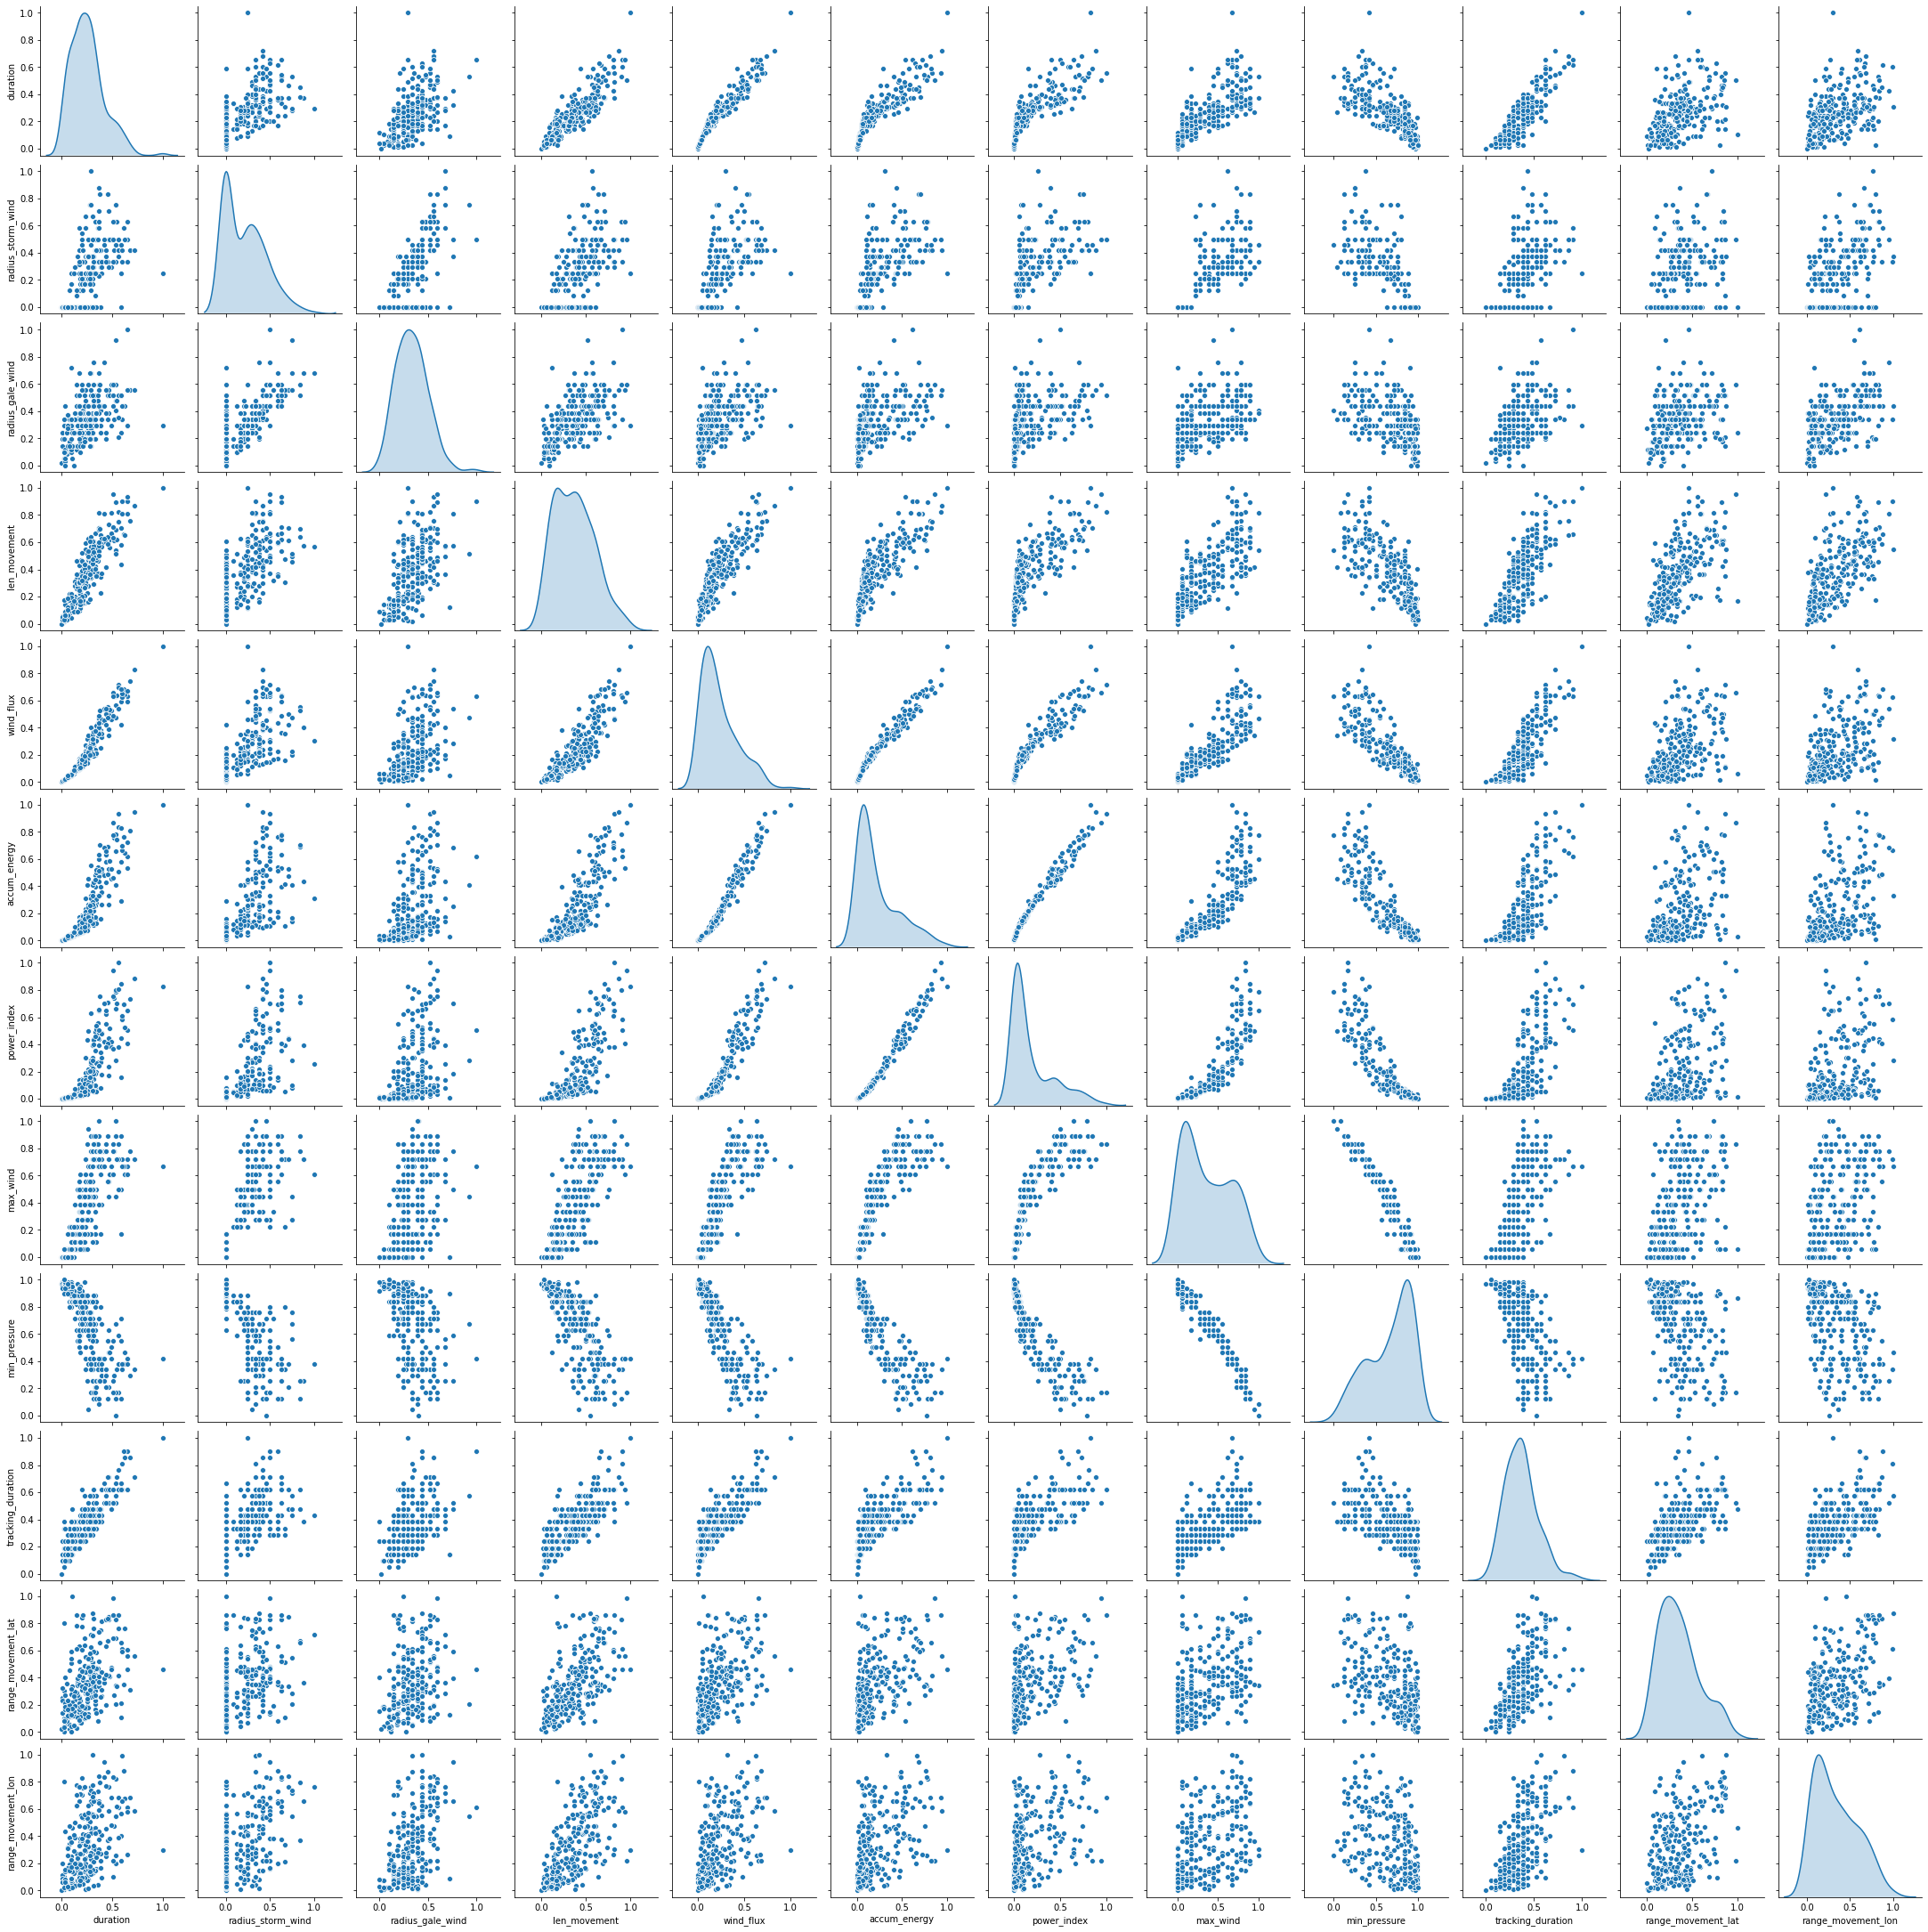

In [ ]:
## Pair-plotting scaled variables
plt.rcParams['figure.figsize'] = (20, 20)
pair_scatter = seaborn.pairplot(sc_typ_2010_2019_df, diag_kind="kde")
pair_scatter.savefig(F"/content/drive/My Drive/postgrad/7008 project/pair_scatter.png")

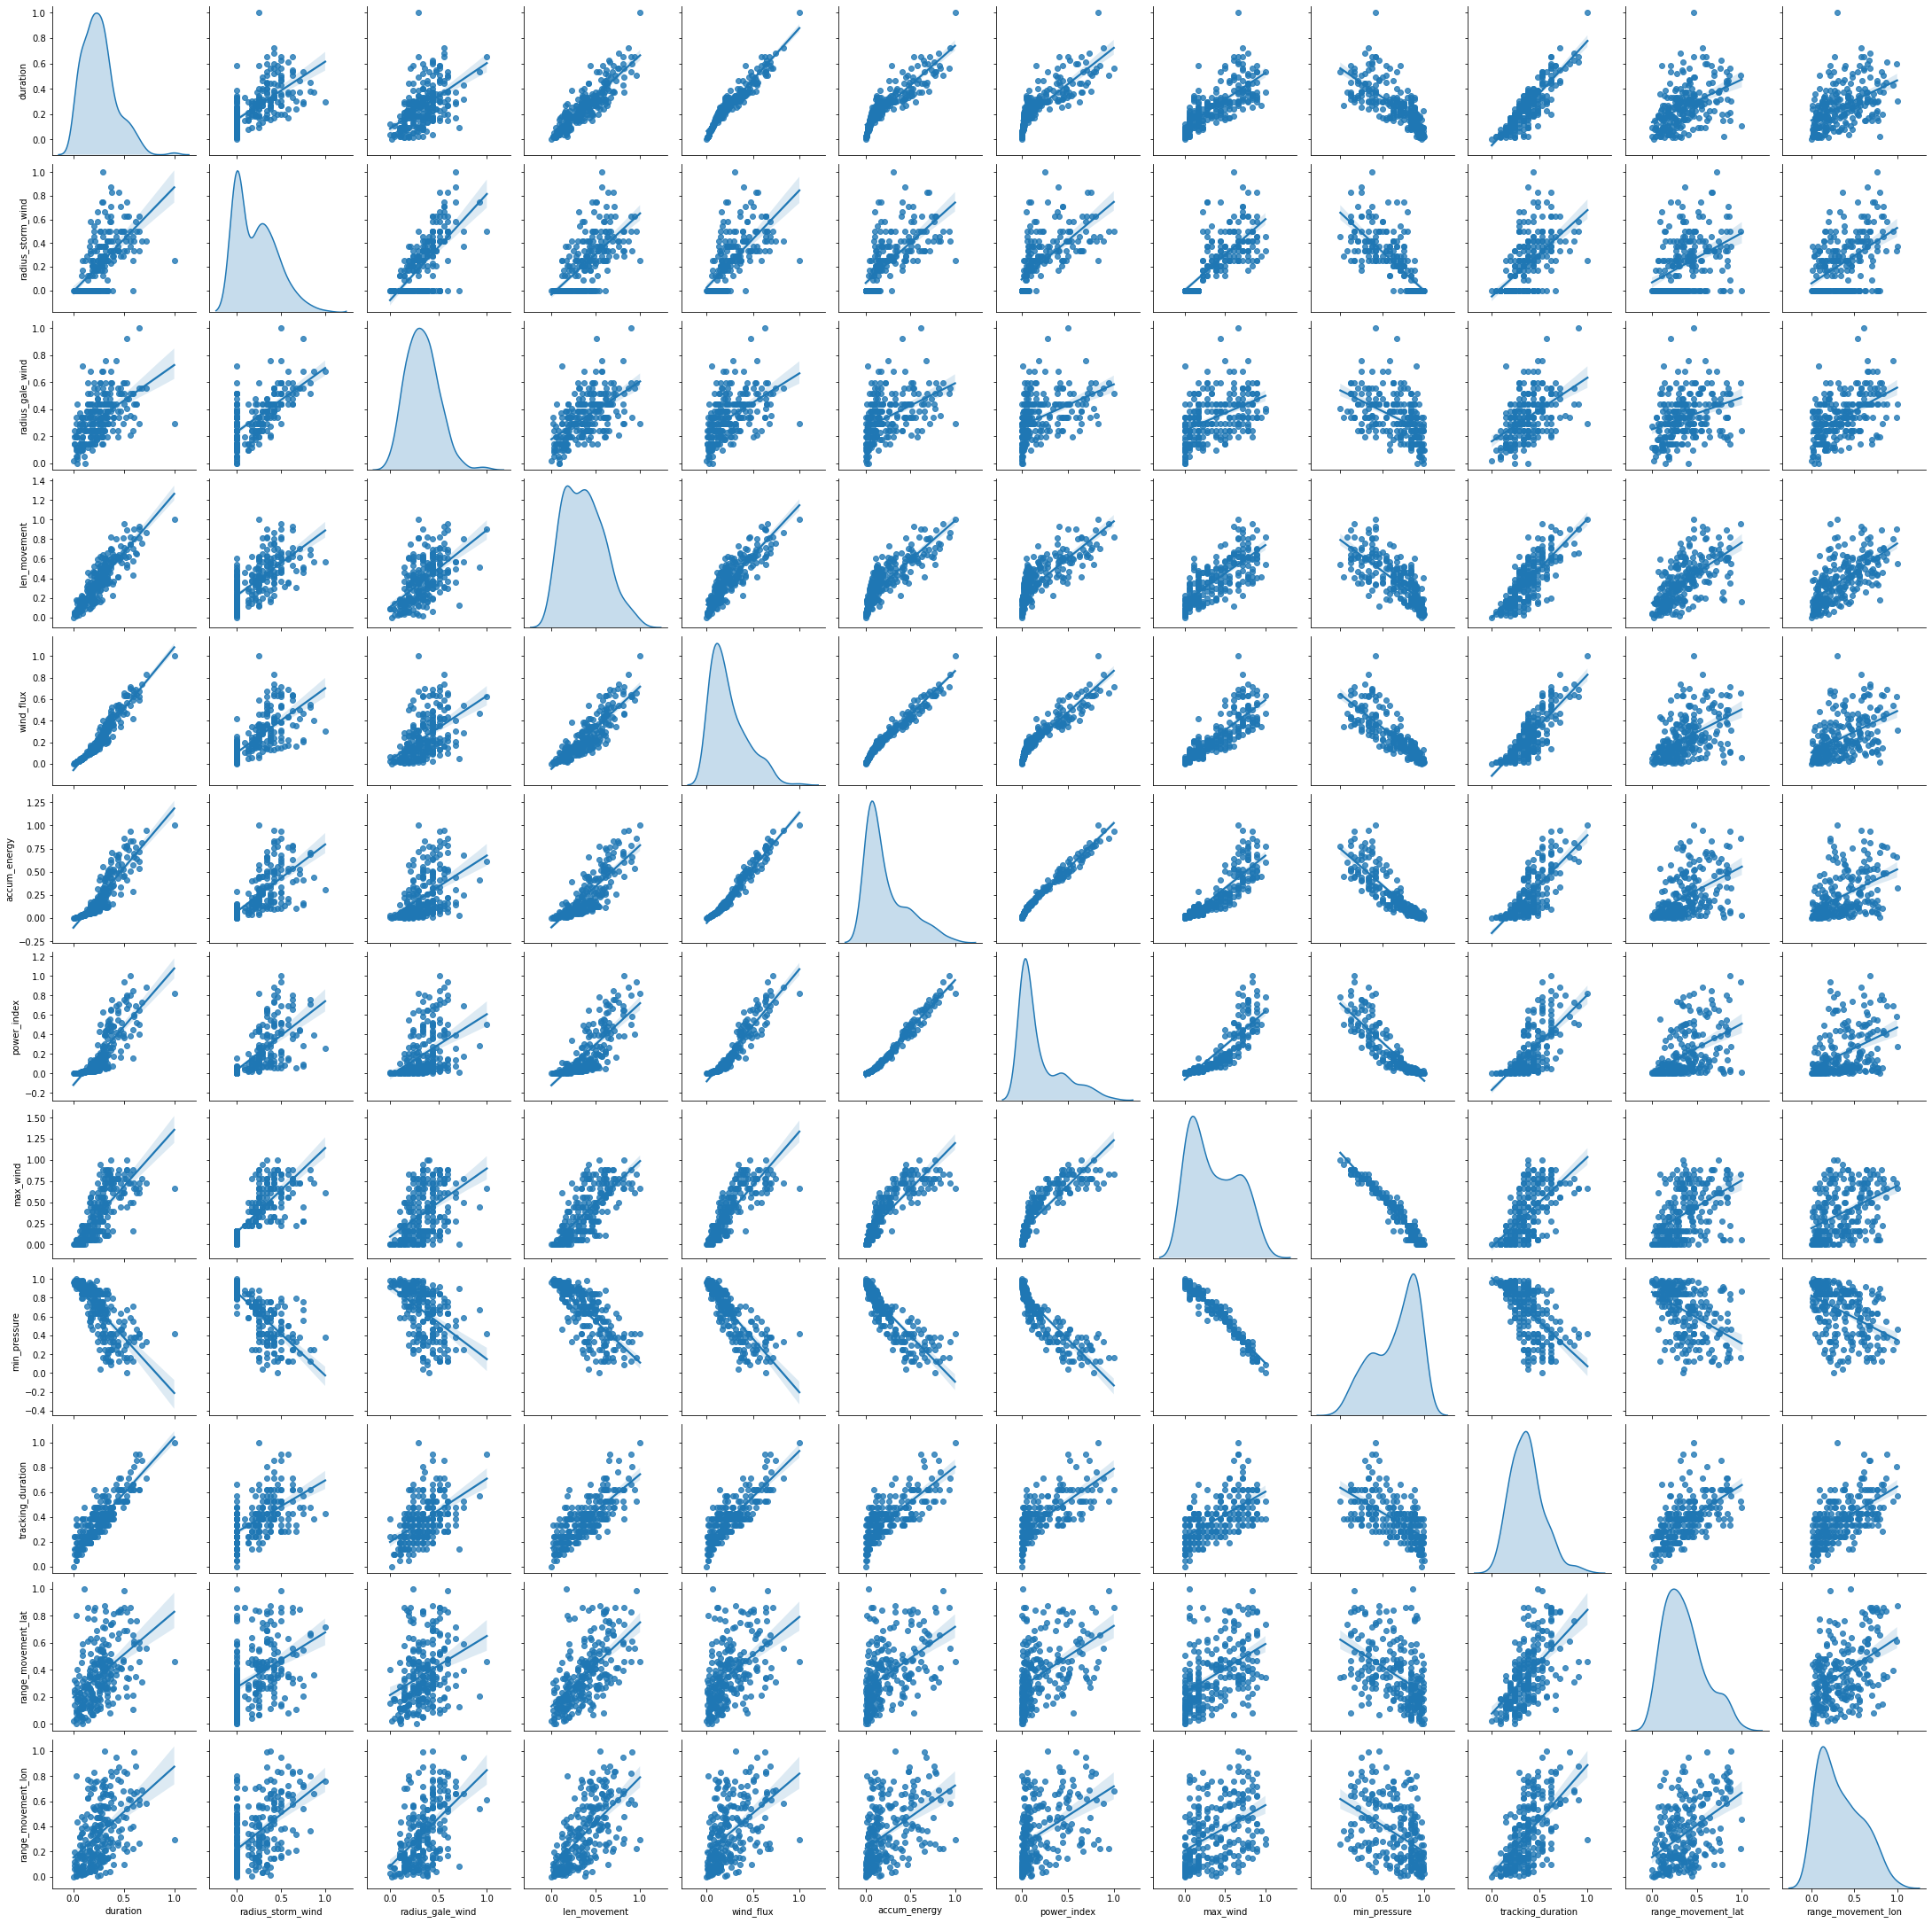

In [ ]:
## Pairwise plotting with linear plots
pairplot = seaborn.pairplot(sc_typ_2010_2019_df, diag_kind="kde", kind="reg")
pairplot.savefig(F"/content/drive/My Drive/postgrad/7008 project/pairplot.png")

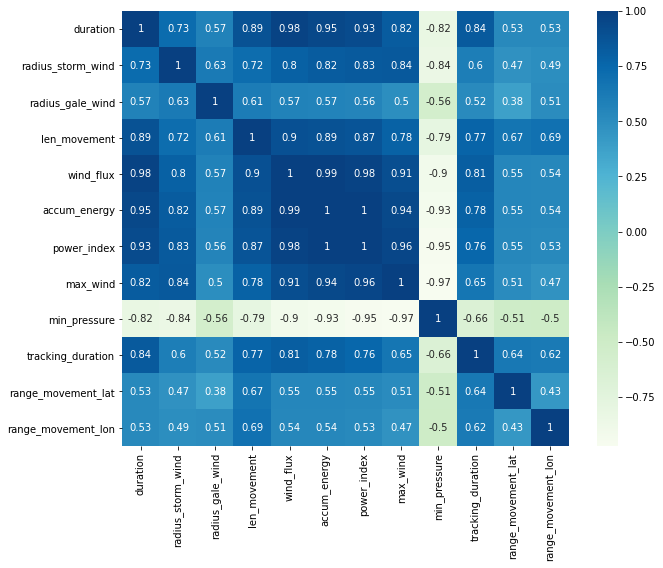

In [ ]:
## Correlation matrix
corr_mat = sc_typ_2010_2019_df.corr(method='spearman')
plt.rcParams['figure.figsize'] = (10, 8)
cor_heatmap = seaborn.heatmap(corr_mat, annot=True, cmap="GnBu")
cor_heatmap.get_figure().savefig(F"/content/drive/My Drive/postgrad/7008 project/cor_heatmap.png")

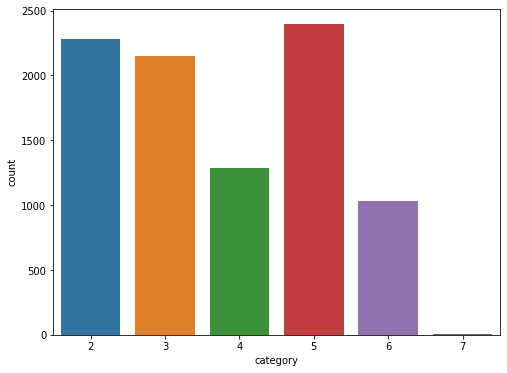

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
seaborn.countplot(x="category", data=track_df)

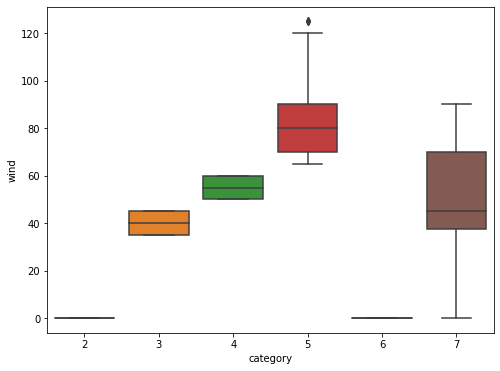

In [ ]:
## boxplot of wind speeds and pressures by category
boxplot_w = seaborn.boxplot(y="wind", x="category", data=track_df)

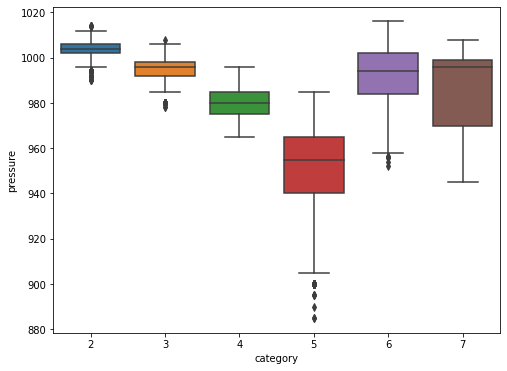

In [ ]:
boxplot_p = seaborn.boxplot(y="pressure", x="category", data=track_df)

In [ ]:
## combine category 6 and category 7 (both probably refer to after-storm-peak low-pressure area)
track_df['category'] = track_df['category'].apply(lambda x: 6 if x == 7 else x)

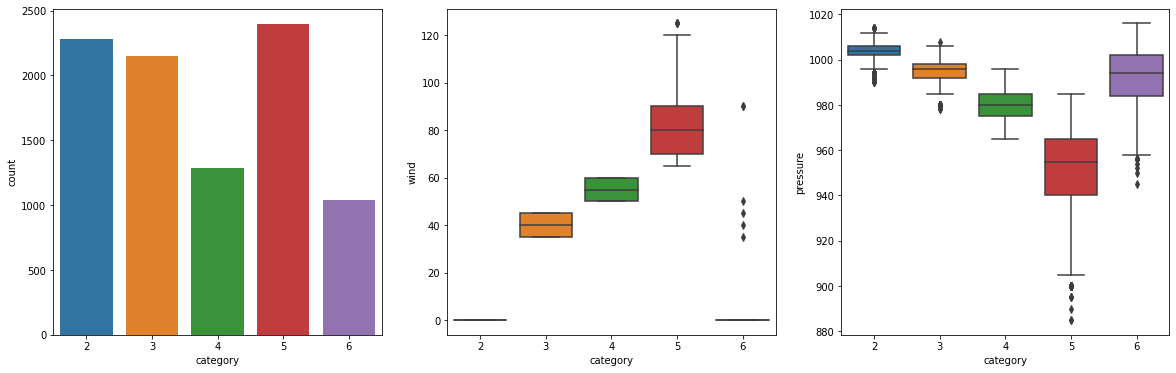

In [ ]:
plt.rcParams['figure.figsize'] = (20, 6)
f, ax = plt.subplots(1, 3)
seaborn.countplot(x="category", data=track_df, ax=ax[0])
seaborn.boxplot(y="wind", x="category", data=track_df, ax=ax[1])
seaborn.boxplot(y="pressure", x="category", data=track_df, ax=ax[2])

In [ ]:
## Time Series of wind speeds and central pressure per typhoon
## serialize the time range by creating the timestep column
timestep = []
timestep.append(0)
counter = 0
for i in range(1, len(track_df)):
    if track_df.iloc[i, 0] == track_df.iloc[i-1, 0]:
        counter += 1
        timestep.append(counter)
    else:
        counter = 0
        timestep.append(counter)

track_df['timestep'] = pd.DataFrame(timestep)
track_df['identity'] = track_df['id'] + ' - ' + track_df['name']

In [ ]:
track_df

id      name  latitude  ...  pressure  timestep           identity
0     201001     OMAIS     141.7  ...      1006         0     201001 - OMAIS
1     201001     OMAIS     140.7  ...      1004         1     201001 - OMAIS
2     201001     OMAIS     139.7  ...      1002         2     201001 - OMAIS
3     201001     OMAIS     138.7  ...      1002         3     201001 - OMAIS
4     201001     OMAIS     137.3  ...      1004         4     201001 - OMAIS
...      ...       ...       ...  ...       ...       ...                ...
9145  201929  PHANFONE     115.2  ...      1006        34  201929 - PHANFONE
9146  201929  PHANFONE     114.0  ...      1008        35  201929 - PHANFONE
9147  201929  PHANFONE     113.0  ...      1010        36  201929 - PHANFONE
9148  201929  PHANFONE     112.2  ...      1012        37  201929 - PHANFONE
9149  201929  PHANFONE     111.7  ...      1012        38  201929 - PHANFONE

[9150 rows x 10 columns]

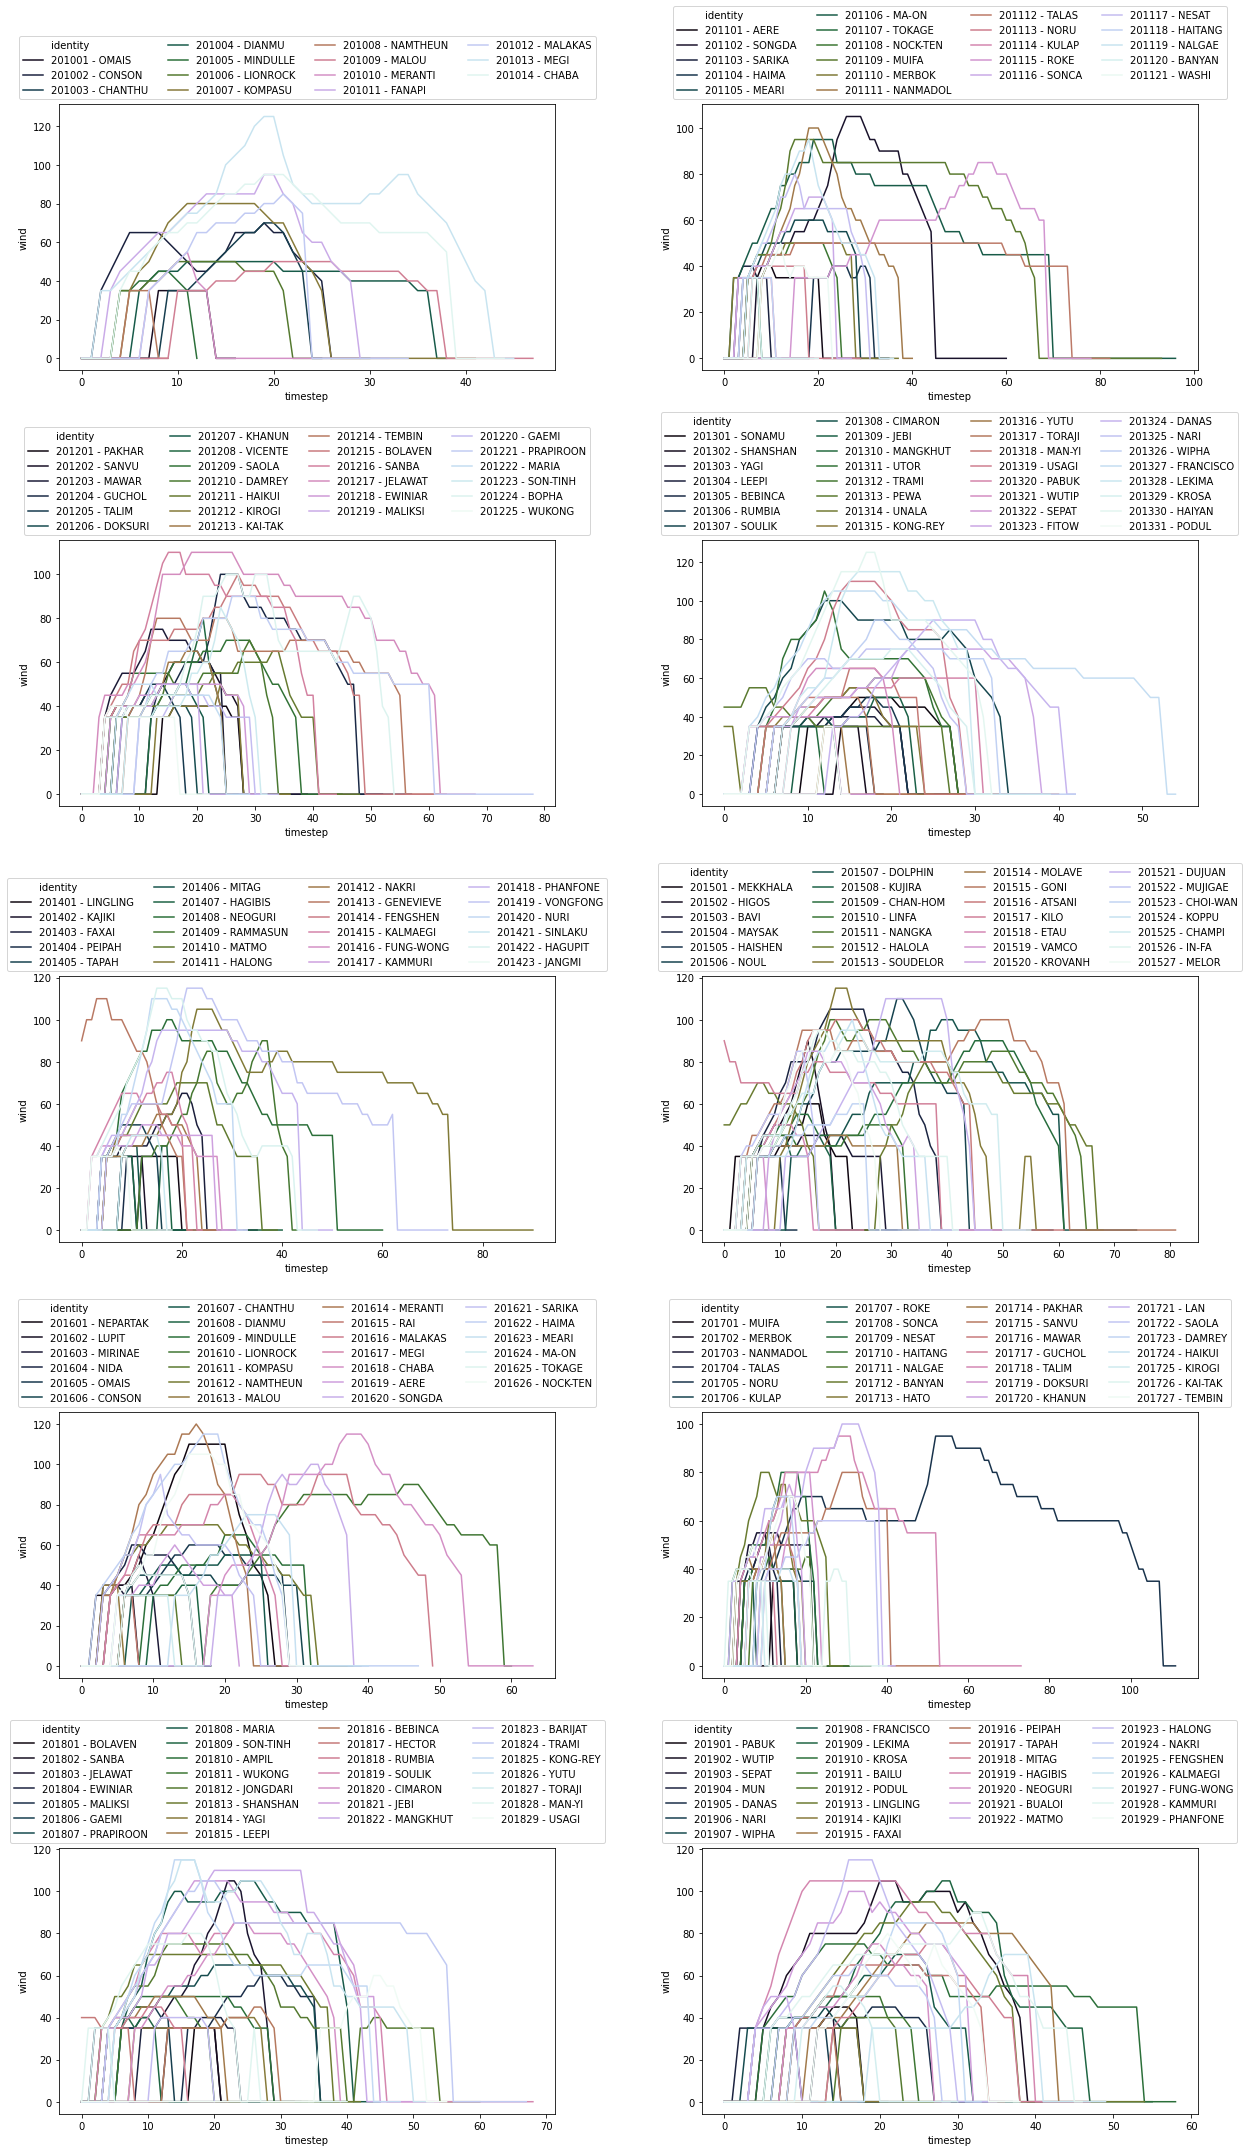

In [ ]:
## plotting typhoon tracking data per year

plt.rcParams['figure.figsize'] = (18, 30)
f, ax = plt.subplots(5, 2)
year = 2010
for m in range(5):
    for n in range(2):
        timeplot = seaborn.lineplot(x='timestep', y='wind', hue='identity', data=track_df[track_df['id'].str.contains(str(year))], 
                                    estimator=None, palette="cubehelix", ax=ax[m,n])
        ax[m,n].legend(loc='lower center', bbox_to_anchor=(0.5,1.0), ncol=4)
        year += 1
plt.tight_layout()

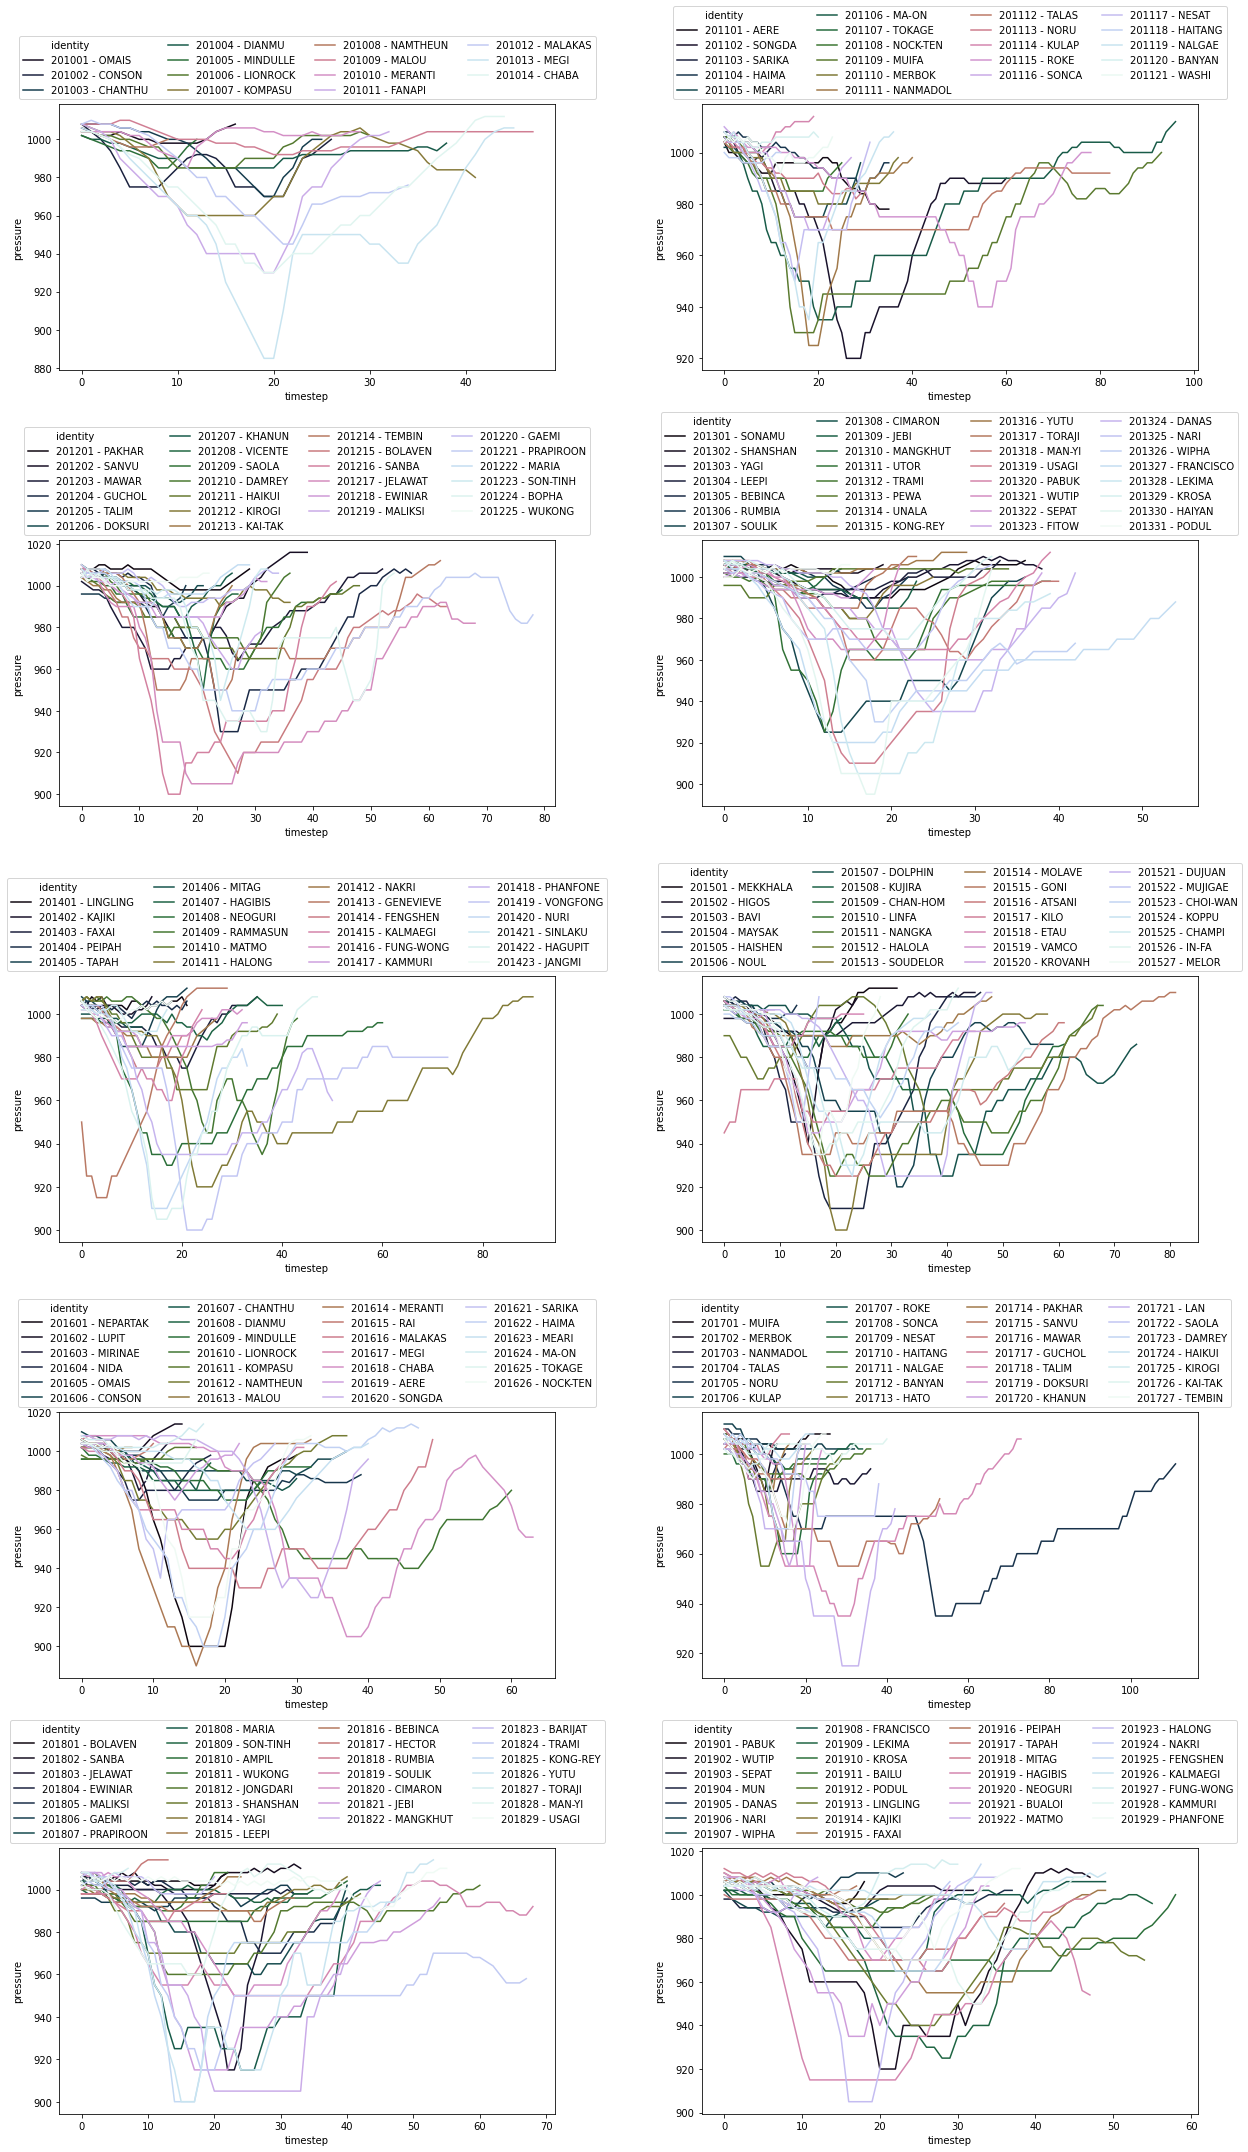

In [ ]:
plt.rcParams['figure.figsize'] = (18, 30)
f, ax = plt.subplots(5, 2)
year = 2010
for m in range(5):
    for n in range(2):
        timeplot = seaborn.lineplot(x='timestep', y='pressure', hue='identity', data=track_df[track_df['id'].str.contains(str(year))], 
                                    estimator=None, palette="cubehelix", ax=ax[m,n])
        ax[m,n].legend(loc='lower center', bbox_to_anchor=(0.5,1.0), ncol=4)
        year += 1
plt.tight_layout()

<b> Time-series Clustering:</b>

From the above pre-processing steps, I got two sets of data, with set 1 containing 252 rows treating single typhoon as one record, while the other set 2 had 9150 rows such that the time-series of the lifetime observation data over 6-hour spaced intervals of each typhoon were presented. While set 1 could be treated as independent observations applying usual partition clustering algorithms like hierarchical clustering and k-means, or density based clustering accounting neighbouring proximity which could act as an outlier detector for extremely performed typhoons in the past records.

Set 1: <br>
a) DBSCAN <br>
b) Hierarchical / Agglomerative Clustering <br>
c) K-means

Set 2: <br>
a) Time-series K-means with DTW (Dynamic Time Wrapping) distance <br>
b) Global Alignment Kernel K-means



Density-based clustering (DBSCAN) applying the concept of k-nearest neighbours (k-NN) incorporated the functionality of finding outliers, which were the points beyond the reachability distance of their nearest neighbouring points in the dimensional space. Reachability distance is a parameter customized by users, the smaller it is, the more deviated points would be regarded as outliers. A k-NN distance plot against the n-th nearest neighbour could be a guided rule of thumb for selecting this parameter. To visualize the outliers, dimensionality reduction techniques like principal component (PCA) and t-distributed neighbour embedding (t-SNE) were employed to project the 12 dimensions to 2 dimensions.

To partition the data, Ward-distance based hierarchical clustering would require the examination of the dendrogram generated, a probable cut-off threshold could be set to prune the cluster tree and hence determining approximately the number of clusters to be chosen for investigations. Meanwhile, another method was performing K-means clustering. To determine the number of clusters, it would be validating through a range of specified clusters, plotting the within-cluster sum-of-square distances and observing the knee point of the curve.


In [ ]:
## Clustering per typhoon based on duration, movement distances, wind intensity
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

Text(0, 0.5, 'k-NN distance')

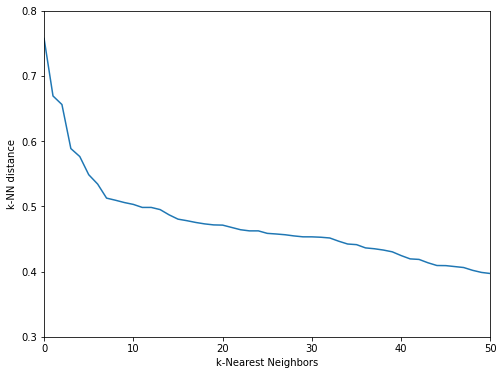

In [ ]:
from sklearn.neighbors import NearestNeighbors
## k-NN distance plot for DBSCAN

nbrs = NearestNeighbors(n_neighbors=4).fit(sc_typ_2010_2019_df)
distances, indices = nbrs.kneighbors(sc_typ_2010_2019_df)
distanceDec = sorted(distances[:,3], reverse=True)

plt.plot(indices[:,0], distanceDec)
plt.xlim(0, 50)
plt.xlabel("k-Nearest Neighbors")
plt.ylim(0.3, 0.8)
plt.ylabel("k-NN distance")


Detailed scatterplots with marginal distribution plots of PCA and t-SNE reduced coordinates in 2 dimensions could be found below. In simple words, t-SNE differs from PCA for being probabilistic and non-linear that uses a metric like Kullback-Leibler (KL) divergence to undergo gradient descent, and trying to preserve the local structure and variation, as compared to PCA being deterministic optimizing the variation in the global structure, with eigenvalue decomposition approach to get first few components.

The k-NN distance plot given above suggested around 0.5 (scree point) to be a proper choice of the reachability distance parameter. Running DBSCAN, in total, 13 typhoons were regarded as being isolated from other clusters. Interestingly, three renowned typhoons in 2018 were on the list, including Typhoon Mangkhut, well-known for the rise of signal number 10 and destructive consequences in Hong Kong; Typhoon Jebi, causing the most serios disruption to Kansai Airport in West Japan; Typhoon Yutu, of similar intensity to Mangkhut striking Philippines. Among the others, some typhoons had similar trajectories of heading to Japan and then entering high-latitude zones ending up in North Pacific Ocean with an extensive long track. Examples included Typhoon Hagibis, Typhoon VongFong and Typhoon Sepat.

In [ ]:
## DBSCAN
dbscan_ = DBSCAN(eps=0.5, min_samples=10, metric='euclidean').fit(sc_typ_2010_2019_df)

In [ ]:
## dimensionality reduction to 2-D by t-SNE and visualize the cluster distribution
from sklearn.manifold import TSNE
reduce_ = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, 
               n_iter=1000, random_state=42).fit_transform(sc_typ_2010_2019_df)

In [ ]:
## dimensionality reduction to 2-D by PCA and visualize the cluster distribution
from sklearn.decomposition import PCA
pca_ = PCA(n_components=2).fit_transform(sc_typ_2010_2019_df)

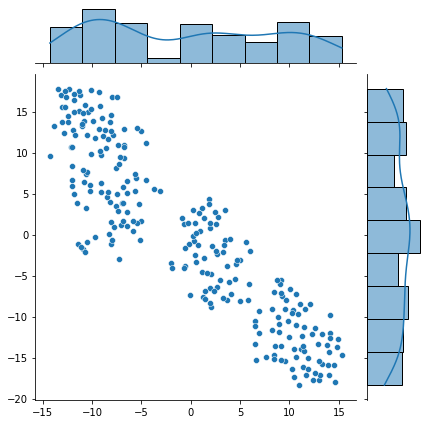

In [ ]:
## T-SNE
reduce_plot = seaborn.JointGrid(x=reduce_[:,0], y=reduce_[:,1])
reduce_plot.plot_joint(seaborn.scatterplot)
reduce_plot.plot_marginals(seaborn.histplot, kde=True)

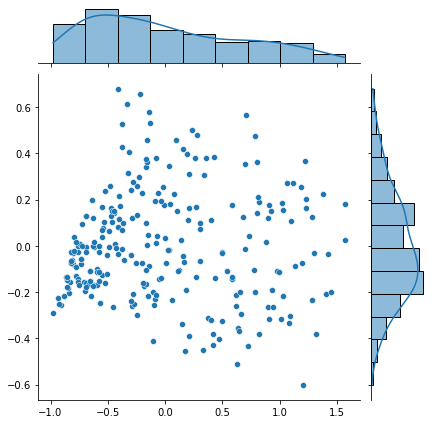

In [ ]:
## PCA
reduce_plot2 = seaborn.JointGrid(x=pca_[:,0], y=pca_[:,1])
reduce_plot2.plot_joint(seaborn.scatterplot)
reduce_plot2.plot_marginals(seaborn.histplot, kde=True)

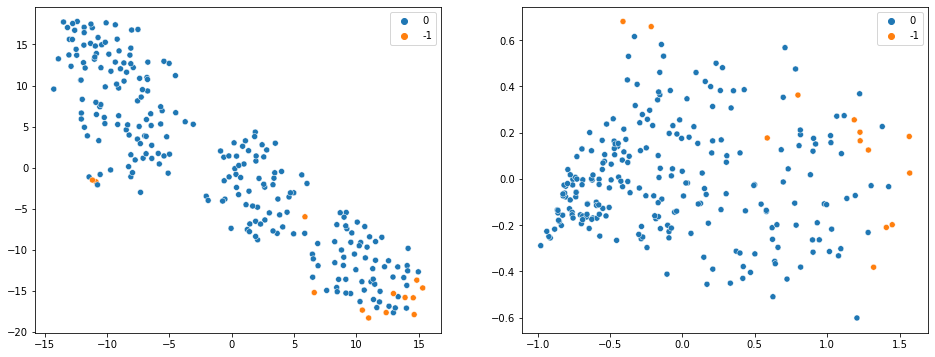

In [ ]:
plt.rcParams['figure.figsize'] = (16, 6)
fig, ax = plt.subplots(1, 2)

seaborn.scatterplot(x=reduce_[:,0], y=reduce_[:,1], hue=[str(x) for x in dbscan_.labels_], legend="full", ax=ax[0])
seaborn.scatterplot(x=pca_[:,0], y=pca_[:,1], hue=[str(x) for x in dbscan_.labels_], legend="full", ax=ax[1])

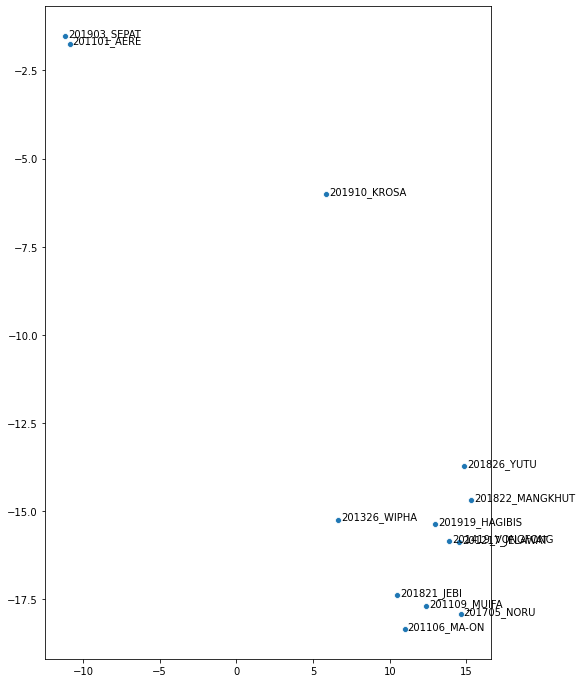

In [ ]:
## t-SNE coordinates for outliers

plt.rcParams['figure.figsize'] = (8, 12)
seaborn.scatterplot(x=reduce_[dbscan_.labels_ == -1, 0], y=reduce_[dbscan_.labels_ == -1, 1])
outlier_typhoon = typ_2010_2019_df[['id', 'name']][dbscan_.labels_ == -1].reset_index(drop=True)
for x in range(len(reduce_[dbscan_.labels_ == -1])):
    plt.text(reduce_[dbscan_.labels_ == -1][x, 0] + .2, 
             reduce_[dbscan_.labels_ == -1][x, 1], 
             outlier_typhoon.iloc[x, 0] + '_' + outlier_typhoon.iloc[x, 1])

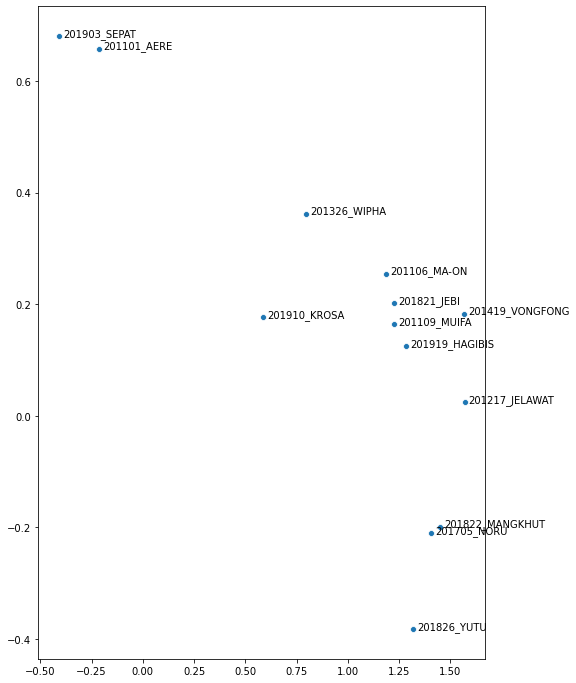

In [ ]:
## PCA coordinates for outliers

plt.rcParams['figure.figsize'] = (8, 12)
seaborn.scatterplot(x=pca_[dbscan_.labels_ == -1, 0], y=pca_[dbscan_.labels_ == -1, 1])
outlier_typhoon = typ_2010_2019_df[['id', 'name']][dbscan_.labels_ == -1].reset_index(drop=True)
for x in range(len(pca_[dbscan_.labels_ == -1])):
    plt.text(pca_[dbscan_.labels_ == -1][x, 0] + .02, 
             pca_[dbscan_.labels_ == -1][x, 1], 
             outlier_typhoon.iloc[x, 0] + '_' + outlier_typhoon.iloc[x, 1])

Through K-means, 10 to 15 clusters were reasonable choices for running the analysis. Considering the complexity, 10-cluster solution was attempted here. For the visualization on the PCA dimensions, it could be seen that most points within the same clusters were successfully grouped in close proximity, except cluster 2 and 9 were overlapping. In the t-SNE reduced dimensions, the 10 clusters could be further split into 3 larger groups:  (1, 6, 7, 8), (3, 4), and (0, 2, 5, 9). 

<ul>
<li>The first group was formed by weak typhoons with high central pressure above 980 hPa, especially cluster 7 was the tropical depression cluster, as it had the shortest average sustaining duration and movement among all groups. </li>
<li>The second group consisted of moderate and intermediate typhoons, the range of travel and the internal wind distributions differentiated the two internal classes within the group. Typhoons in cluster 4 affected a greater area and were more long-lasting than those in cluster 3 on average, meanwhile having a greater radius of strong winds from the center, which probably meant the average size of the storms was also larger or the winds were less compacted in the centric zone. </li>
<li>The third group referred to strong-to-violent level typhoons. Typhoons in cluster 0 and cluster 9 were the most powerful, cluster 9 was at the same time most long-lasting and moving the furthest distance. Cluster 5 was recognized by greatest radius of storm winds. </li>
</ul>


In [ ]:
wss_cluster = []
for n in range(2, 31):
    kmeans_ = KMeans(n_clusters = n).fit(sc_typ_2010_2019_df)
    wss_cluster.append(kmeans_.inertia_)

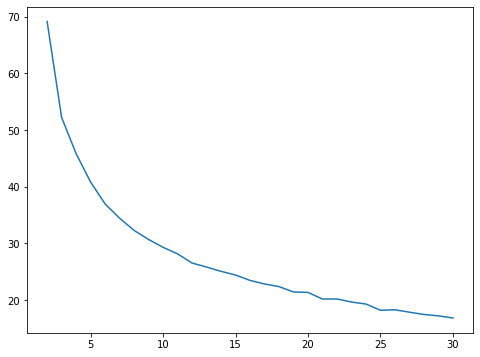

In [ ]:
## determine number of clusters in k-means
plt.plot(np.arange(2, 31).tolist(), wss_cluster)

In [ ]:
kmeans_ = KMeans(n_clusters = 10).fit(sc_typ_2010_2019_df)

10-cluster plots by K-means (Top-Left: 2-D coordinates reduced by PCA; Top-Right: 2-D coordinates reduced by t-SNE)

i)	Middle-Left: minimum pressure against maximum wind speed by 10 clusters; 
ii)	Middle-Right: range of coverage in latitude and longitude by 10 clusters; 
iii)	Bottom-Left: duration against straight-line length of movement by 10 clusters; 
iv)	Bottom-Right: radius of gale wind and storm wind by 10 clusters



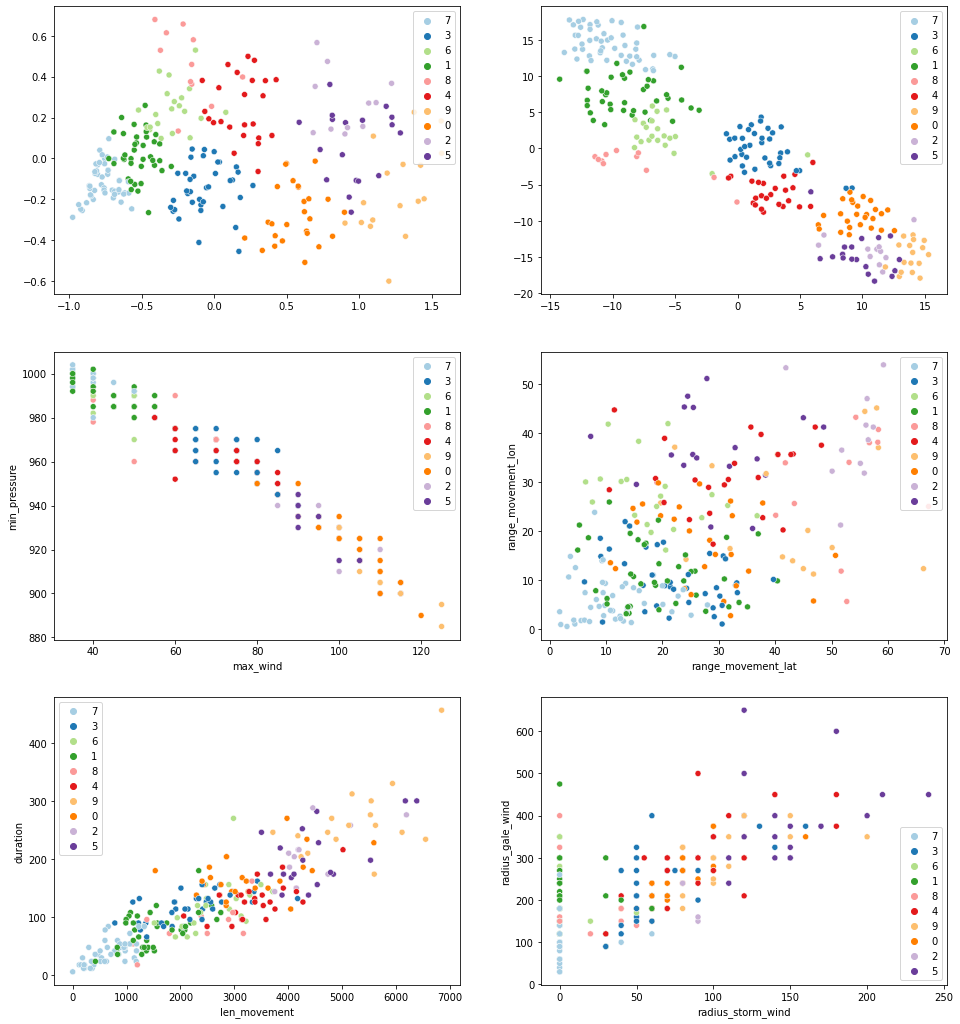

In [ ]:
plt.rcParams['figure.figsize'] = (16, 18)
fig, ax = plt.subplots(3, 2)

print("10-cluster plots by K-means (Top-Left: 2-D coordinates reduced by PCA; Top-Right: 2-D coordinates reduced by t-SNE)")
print("")
print("i)	Middle-Left: minimum pressure against maximum wind speed by 10 clusters; " + "\n" + \
      "ii)	Middle-Right: range of coverage in latitude and longitude by 10 clusters; " + "\n" + \
      "iii)	Bottom-Left: duration against straight-line length of movement by 10 clusters; " + "\n" + \
      "iv)	Bottom-Right: radius of gale wind and storm wind by 10 clusters")
print("")

## Visualize through PCA / t-SNE two dimension plots
seaborn.scatterplot(x=pca_[:,0], y=pca_[:,1], hue=[str(x) for x in kmeans_.labels_], legend="full", palette="Paired", ax=ax[0,0])
seaborn.scatterplot(x=reduce_[:,0], y=reduce_[:,1], hue=[str(x) for x in kmeans_.labels_], legend="full", palette="Paired", ax=ax[0,1])

## Visualize the physical features among clusters
seaborn.scatterplot(x=typ_2010_2019_df['max_wind'], y=typ_2010_2019_df['min_pressure'], 
                    hue=[str(x) for x in kmeans_.labels_], legend="full", palette="Paired", ax=ax[1,0])
seaborn.scatterplot(x=typ_2010_2019_df['range_movement_lat'], y=typ_2010_2019_df['range_movement_lon'], 
                    hue=[str(x) for x in kmeans_.labels_], legend="full", palette="Paired", ax=ax[1,1])
seaborn.scatterplot(x=typ_2010_2019_df['len_movement'], y=typ_2010_2019_df['duration'], 
                    hue=[str(x) for x in kmeans_.labels_], legend="full", palette="Paired", ax=ax[2,0])
seaborn.scatterplot(x=typ_2010_2019_df['radius_storm_wind'], y=typ_2010_2019_df['radius_gale_wind'], 
                    hue=[str(x) for x in kmeans_.labels_], legend="full", palette="Paired", ax=ax[2,1])

In determining the appropriate number of clusters, the dendrogram generated from doing the hierarchical clustering could also provide some insights. With Ward's distance as the agglomeration metrics, all individual points started with itself being a cluster and merged to form larger clusters, eventually covering all data points. With cut-off set at 2.0 there would be 7 or 8 clusters identified. Comparing the 8-cluster solution from hierarchical clustering and 10-cluster solution from K-means, approximately, clusters 2 and 5 of the K-means cluster labels had been merged, while clusters 4 was split and partly merged with clusters 0 and 8. 

Both results generally agreed with each other. Applying the t-SNE visualization, the 10 clusters seems to be more clearly cut than the 8 clusters, because cluster 0 and cluster 3 in the 8-cluster solution spread over the top-left large partition group and the middle large partition group, while on the PCA visualization, 10 clusters are more overlapping, more principal components might be required.



In [ ]:
## Hierarchical clustering solution
hierar_clust_ = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(sc_typ_2010_2019_df)

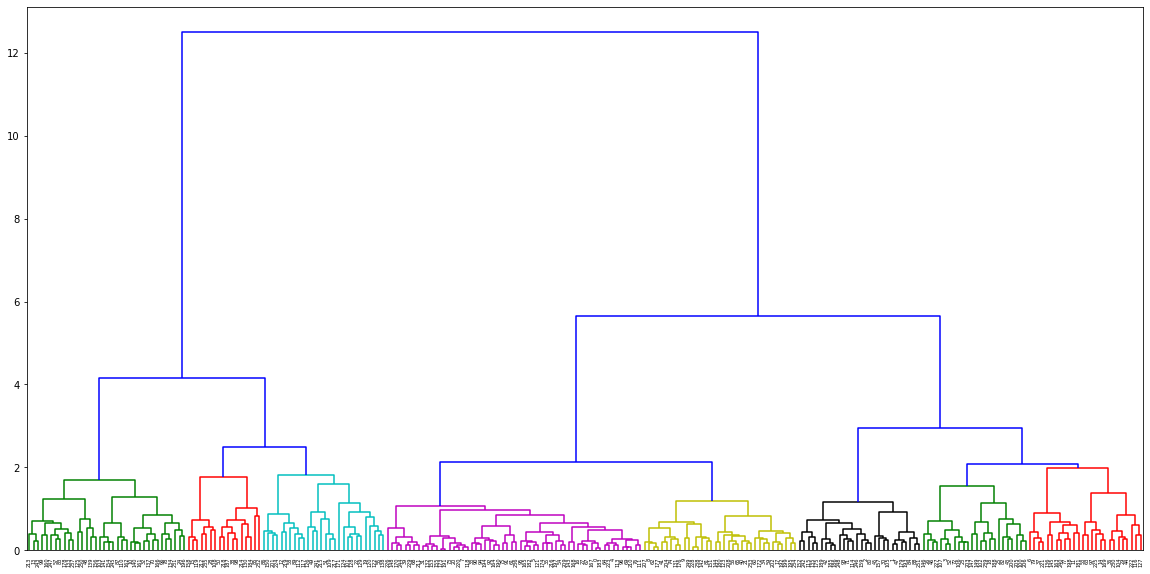

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(hierarchical_cluster, color_threshold, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(hierarchical_cluster.children_.shape[0])
    n_samples = len(hierarchical_cluster.labels_)
    for i, merge in enumerate(hierarchical_cluster.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    ## linkage matrix for dendogram plotting in scipy
    linkage_matrix = np.column_stack([hierarchical_cluster.children_, hierarchical_cluster.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=color_threshold, **kwargs)

plt.rcParams['figure.figsize'] = (20, 10)
plot_dendrogram(hierar_clust_, 2)

In [ ]:
hierar_clust_2 = AgglomerativeClustering(distance_threshold=2, n_clusters=None, linkage='ward').fit(sc_typ_2010_2019_df)

8-cluster plots by hierarchical clustering (Top-Left: 2-D coordinates reduced by PCA; Top-Right: 2-D coordinates reduced by t-SNE)

i)	Middle-Left: minimum pressure against maximum wind speed by 8 clusters; 
ii)	Middle-Right: duration against straight-line length of movement by 8 clusters; 
iii)	Bottom-Left: range of coverage in latitude and longitude by 8 clusters; 
iv)	Bottom-Right: radius of gale wind and storm wind by 8 clusters



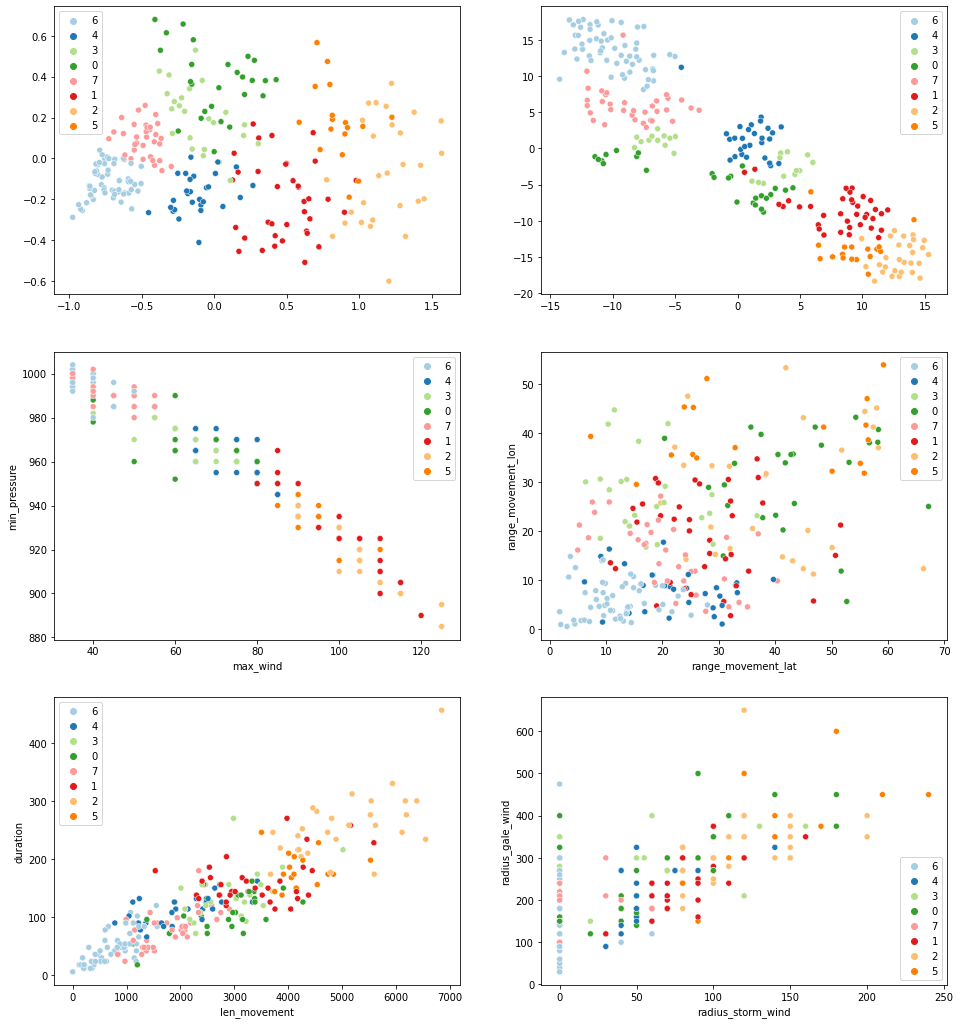

In [ ]:
plt.rcParams['figure.figsize'] = (16, 18)
fig, ax = plt.subplots(3, 2)

print("8-cluster plots by hierarchical clustering (Top-Left: 2-D coordinates reduced by PCA; Top-Right: 2-D coordinates reduced by t-SNE)")
print("")
print("i)	Middle-Left: minimum pressure against maximum wind speed by 8 clusters; " + "\n" + \
      "ii)	Middle-Right: range of coverage in latitude and longitude by 8 clusters; " + "\n" + \
      "iii)	Bottom-Left: duration against straight-line length of movement by 8 clusters; " + "\n" + \
      "iv)	Bottom-Right: radius of gale wind and storm wind by 8 clusters")
print("")

## Visualize through PCA / t-SNE two dimension plots
seaborn.scatterplot(x=pca_[:,0], y=pca_[:,1], hue=[str(x) for x in hierar_clust_2.labels_], legend="full", palette="Paired", ax=ax[0,0])
seaborn.scatterplot(x=reduce_[:,0], y=reduce_[:,1], hue=[str(x) for x in hierar_clust_2.labels_], legend="full", palette="Paired", ax=ax[0,1])

## Visualize the physical features among clusters
seaborn.scatterplot(x=typ_2010_2019_df['max_wind'], y=typ_2010_2019_df['min_pressure'], 
                    hue=[str(x) for x in hierar_clust_2.labels_], legend="full", palette="Paired", ax=ax[1,0])
seaborn.scatterplot(x=typ_2010_2019_df['range_movement_lat'], y=typ_2010_2019_df['range_movement_lon'], 
                    hue=[str(x) for x in hierar_clust_2.labels_], legend="full", palette="Paired", ax=ax[1,1])
seaborn.scatterplot(x=typ_2010_2019_df['len_movement'], y=typ_2010_2019_df['duration'], 
                    hue=[str(x) for x in hierar_clust_2.labels_], legend="full", palette="Paired", ax=ax[2,0])
seaborn.scatterplot(x=typ_2010_2019_df['radius_storm_wind'], y=typ_2010_2019_df['radius_gale_wind'], 
                    hue=[str(x) for x in hierar_clust_2.labels_], legend="full", palette="Paired", ax=ax[2,1])

The original K-means algorithm was applied to features that could be treated independently or existing some correlations (in that case clustering could be applied to principal components obtained from dimensionality reduction, e.g. hierarchical clustering for principal component HCPC). When using time series features to do clustering, the features persist a sequential dependence, the original distance metrics (e.g. Euclidean distance) are not applicable for not accounting for the factor of time shift. 

Instead, dynamic time wrapping (DTW) computes a metric that could represent the degree of alignment across indexed timesteps between two time series. The distance between two paired data in an aligned ordered position of the sequence were to be minimized, this would be the cost function adopted in the Time-series K-means. An alternative would be Kernel K-means, which uses different kernel functions as specified to handle non-linear shapes, like a spectral clustering.

The input matrix for doing time-series clustering would be (sample, timesteps, dimensions). The 6-hour interval monitored data were of 2 dimensions: wind speeds and atmospheric pressure. Since the lifetime of typhoons were different, timesteps (second dimension of the matrix) in this context actually referred to the maximum timestep that the longest existing typhoon attained in the dataset.


In [ ]:
!pip install tslearn

In [ ]:
## generate time series per typhoon
## pivot by each timestep
ts_df = track_df[['identity','timestep','wind','pressure']].pivot('identity','timestep')
## padding missing values due to variable time series length
ts_df = ts_df.fillna(method='pad', axis=1)
## converting into 3d arrays (observation, timestep, time-series data dimension)
ts_df_arr = np.dstack((np.array(ts_df.iloc[:,:ts_df.shape[1]//2]), np.array(ts_df.iloc[:,ts_df.shape[1]//2:])))

In [ ]:
ts_df_arr.shape

(252, 112, 2)

In [ ]:
from tslearn.clustering import GlobalAlignmentKernelKMeans, TimeSeriesKMeans, KernelKMeans, silhouette_score

In [ ]:
sil_score_tskm = []
for m in range(2, 11):
    ts_km_ = TimeSeriesKMeans(n_clusters=m, metric="dtw", 
                              random_state=42, max_iter=100)
    labels = ts_km_.fit_predict(ts_df_arr)
    sil_sc = silhouette_score(ts_df_arr, labels, metric="dtw")
    sil_score_tskm.append(sil_sc)

In [ ]:
sil_score_gakkm = []
for m in range(2, 11):
    gak_km_ = KernelKMeans(n_clusters=m, kernel='gak', 
                          random_state=42, max_iter=100)
    labels = gak_km_.fit_predict(ts_df_arr)
    sil_sc = silhouette_score(ts_df_arr, labels, metric="dtw")
    sil_score_gakkm.append(sil_sc)

Based on the validation on the number of clusters with respect to the silhouette score (to be maximized) obtained from running DTW distance time-series K-means and the global alignment kernel methods, it would be appropriate to choose 2 to 4 clusters. Re-doing the PCA reduction on the time series features for the ease of visualization purpose (note the last two dimension was flattened to get a 2-D shape input matrix), the coordinates of points appeared to be more concentrated. 

DTW distance-based time-series K-means gave quite intuitively interpretable cluster solution when specifying 4 clusters, while the global alignment kernel method was not successsful as the clusters formed were of higher impurity in points of view from the reduced 2-D plot. If we associate this set of time-series feature based cluster label with the aggregated features of corresponding typhoons, the purple-colored cluster 2 was compactly grouped, and was clearly referred to most of the weak and short-lasting tropical depressions. The blue-colored cluster was in general the intermediate-intensity group. 

Interesting result would be the orange-colored cluster (label 1) and red-colored cluster (label 3). The orange-colored cluster seemed to be dispersed over a variation from intermediate to strong typhoons; and the red-colored cluster was generally the strong typhoons while not being the extremes and at the same time had averagely larger impacting areas than the orange cluster. To compare these two clusters, we could extract the time-series given by the centroids, cluster 1 quickly attained peak level, having a shorter lifetime but sustained longer around peak levels; cluster 3 gained energy gradually, peaked at later timesteps but started declining faster.


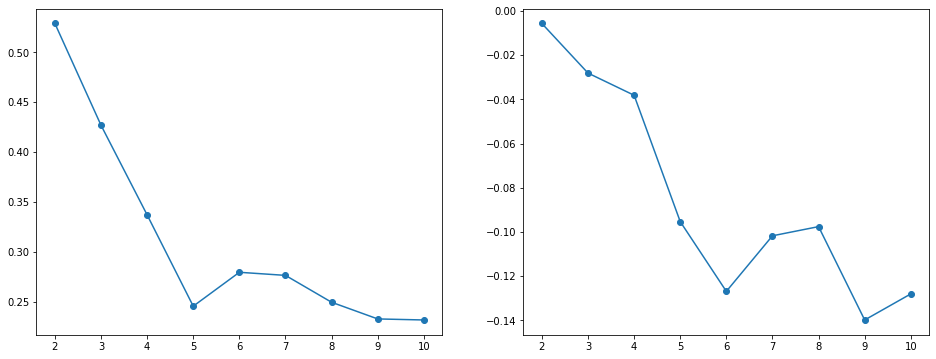

In [ ]:
plt.rcParams['figure.figsize'] = (16, 6)
fig, ax = plt.subplots(1, 2)

## choosing maximum silhouette scores
ax[0].plot(np.arange(2, 11).tolist(), sil_score_tskm, marker='o')
ax[1].plot(np.arange(2, 11).tolist(), sil_score_gakkm, marker='o')

In [ ]:
ts_km_ = TimeSeriesKMeans(n_clusters=4, metric="dtw", 
                          random_state=42, max_iter=100).fit(ts_df_arr)

In [ ]:
ts_km_label = ts_km_.predict(ts_df_arr)

In [ ]:
gak_km_ = KernelKMeans(n_clusters=4, kernel='gak', 
                       random_state=42, max_iter=100).fit(ts_df_arr)

In [ ]:
gak_km_label = gak_km_.predict(ts_df_arr)

In [ ]:
### PCA & t-SNE on time series data
pca_ts_ = PCA(n_components=2).fit_transform(ts_df)
tsne_ts_ = TSNE(n_components=2, random_state=0).fit_transform(ts_df)

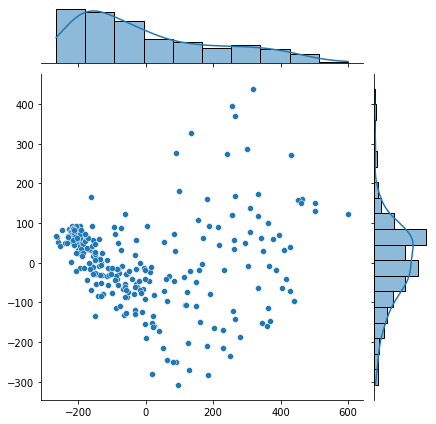

In [ ]:
reduce_plot_ts1 = seaborn.JointGrid(x=pca_ts_[:,0], y=pca_ts_[:,1])
reduce_plot_ts1.plot_joint(seaborn.scatterplot)
reduce_plot_ts1.plot_marginals(seaborn.histplot, kde=True)

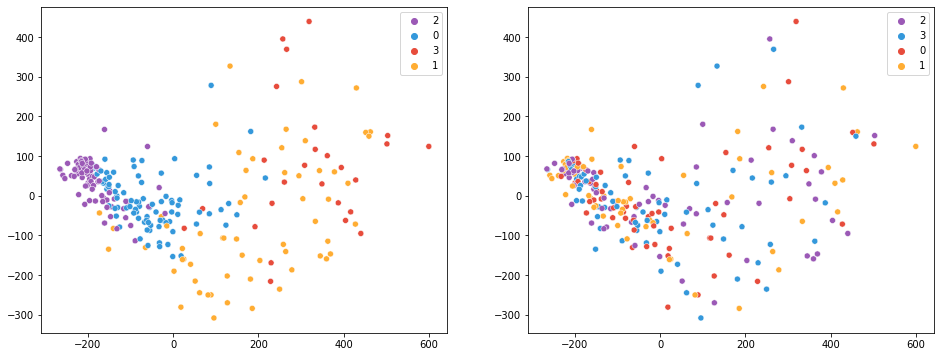

In [ ]:
plt.rcParams['figure.figsize'] = (16, 6)
fig, ax = plt.subplots(1,2)

seaborn.scatterplot(x=pca_ts_[:,0], y=pca_ts_[:,1], hue=[str(x) for x in ts_km_label], legend="full", 
                    palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[0])
seaborn.scatterplot(x=pca_ts_[:,0], y=pca_ts_[:,1], hue=[str(x) for x in gak_km_label], legend="full", 
                    palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[1])

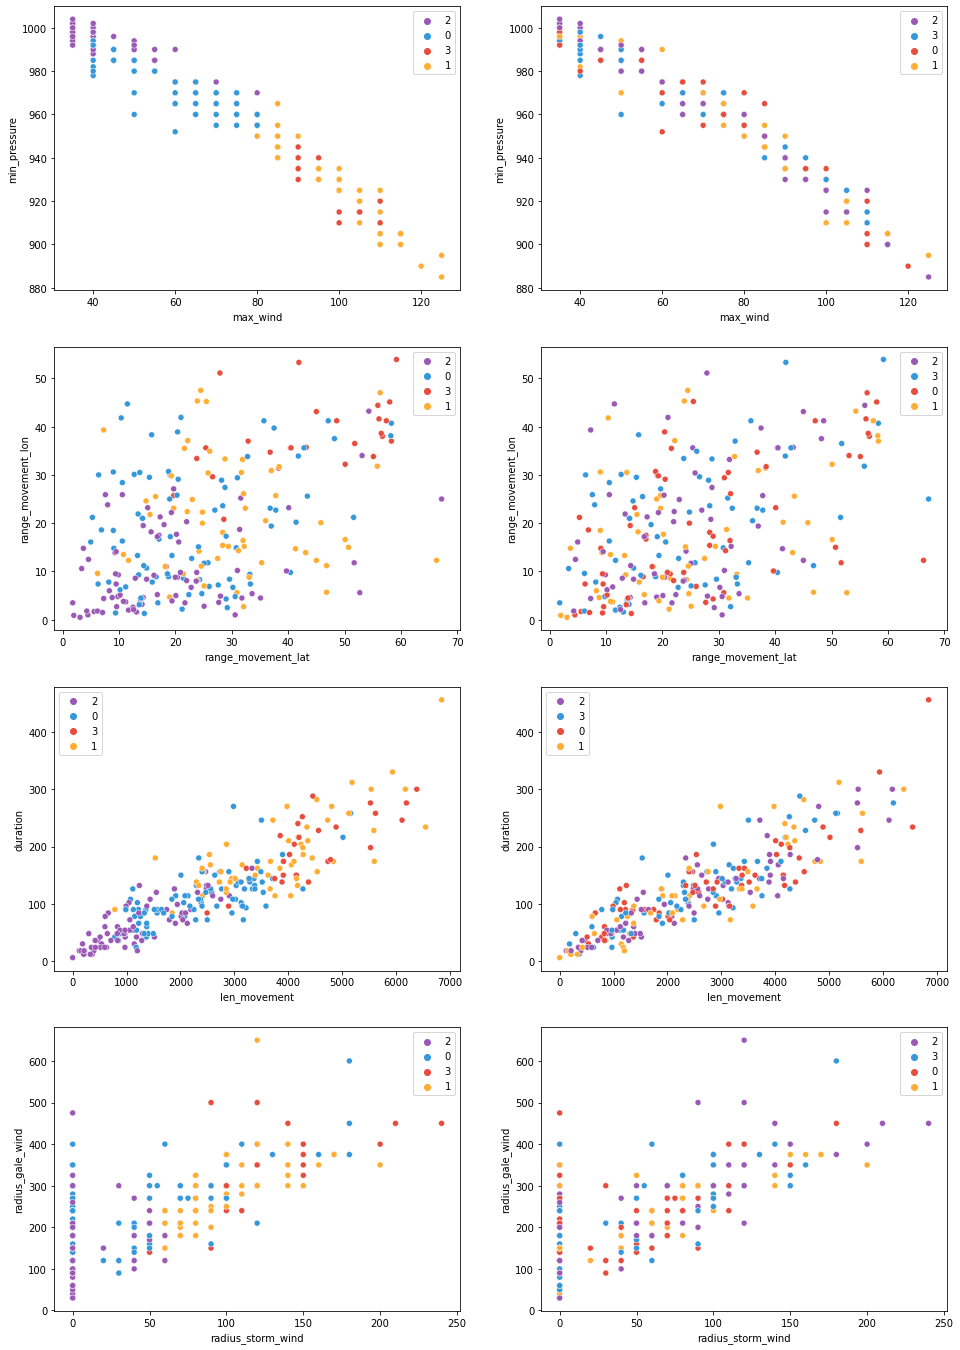

In [ ]:
plt.rcParams['figure.figsize'] = (16, 24)
fig, ax = plt.subplots(4,2)

## Visualize the physical features among clusters
seaborn.scatterplot(x=typ_2010_2019_df['max_wind'], y=typ_2010_2019_df['min_pressure'], 
                    hue=[str(x) for x in ts_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[0,0])
seaborn.scatterplot(x=typ_2010_2019_df['max_wind'], y=typ_2010_2019_df['min_pressure'], 
                    hue=[str(x) for x in gak_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[0,1])

seaborn.scatterplot(x=typ_2010_2019_df['range_movement_lat'], y=typ_2010_2019_df['range_movement_lon'], 
                    hue=[str(x) for x in ts_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[1,0])
seaborn.scatterplot(x=typ_2010_2019_df['range_movement_lat'], y=typ_2010_2019_df['range_movement_lon'], 
                    hue=[str(x) for x in gak_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[1,1])

seaborn.scatterplot(x=typ_2010_2019_df['len_movement'], y=typ_2010_2019_df['duration'], 
                    hue=[str(x) for x in ts_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[2,0])
seaborn.scatterplot(x=typ_2010_2019_df['len_movement'], y=typ_2010_2019_df['duration'], 
                    hue=[str(x) for x in gak_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[2,1])

seaborn.scatterplot(x=typ_2010_2019_df['radius_storm_wind'], y=typ_2010_2019_df['radius_gale_wind'], 
                    hue=[str(x) for x in ts_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[3,0])
seaborn.scatterplot(x=typ_2010_2019_df['radius_storm_wind'], y=typ_2010_2019_df['radius_gale_wind'], 
                    hue=[str(x) for x in gak_km_label], legend="full", palette=["#9b59b6", "#3498db", "#e74c3c", "#ffad33"], ax=ax[3,1])

In [ ]:
## extract centroid
ts_km_centroid = ts_km_.cluster_centers_
centroid_wind = pd.DataFrame(np.transpose(ts_km_centroid[:,:,0]))
centroid_pressure = pd.DataFrame(np.transpose(ts_km_centroid[:,:,1]))
centroid_wind.columns = ['cluster_0','cluster_1','cluster_2','cluster_3']
centroid_pressure.columns = ['cluster_0','cluster_1','cluster_2','cluster_3']

[Text(0, 0.5, 'air_pressure'),
 Text(0.5, 0, 'time_step'),
 Text(0.5, 1.0, 'Cluster 3')]

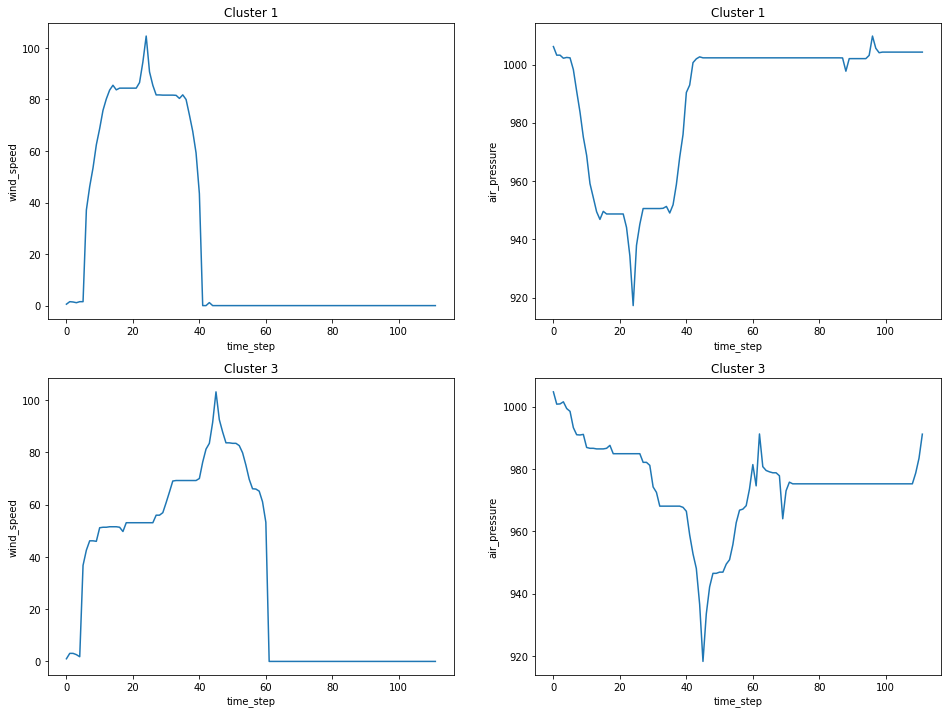

In [ ]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(2,2)
seaborn.lineplot(x = centroid_wind.index, y = 'cluster_1', data = centroid_wind, ax=ax[0,0])
ax[0,0].set(xlabel='time_step', ylabel='wind_speed', title='Cluster 1')
seaborn.lineplot(x = centroid_pressure.index, y = 'cluster_1', data = centroid_pressure, ax=ax[0,1])
ax[0,1].set(xlabel='time_step', ylabel='air_pressure', title='Cluster 1')
seaborn.lineplot(x = centroid_wind.index, y = 'cluster_3', data = centroid_wind, ax=ax[1,0])
ax[1,0].set(xlabel='time_step', ylabel='wind_speed', title='Cluster 3')
seaborn.lineplot(x = centroid_pressure.index, y = 'cluster_3', data = centroid_pressure, ax=ax[1,1])
ax[1,1].set(xlabel='time_step', ylabel='air_pressure', title='Cluster 3')

<b> CNN-LSTM : forecasting the next time-step wind speed, intensity and air pressure with satellite images </b>

The inputted features involved the pixels from satellite images, and the target for forecasting would be temporally sequential in nature. For a neural network approach, Convolutional Neural Network (CNN) is served as a feature extractor or encoder that extracts feature maps and vectors from the images with a set of pre-assigned square filter matrices, performing convolutions sliding over the images and pooling the values obtained. The outputted vectors would represent each individual image in the data. To learn the sequential structure (temporal or spatial) and predicting the next-step observations, Recurrent Neural Network (RNN) is introduced, CNN-RNN is an architecture combining the CNN and RNN, while LSTM (Long-Short Term Memory) network is a commonly used and powerful RNN, CNN-LSTM would be applicable in this context feeding the inputs of images and get time-dependent predictions.

Below graph illustrated the conceptual flow of the CNN-LSTM model. 

<img src ="../CNN-LSTM.png">

Each downloaded images were of te size of 512 x 512, with dimension of 3 channels. Some random example plots were generated as below. 

The first step of the implementation would be to train a CNN, setting the a softmax loss function with respect to the categorized intensity levels (indicator of perceived typhoon strongness) by the wind speed, as well as a linear loss function with respect to air pressure. The trained latent feature vectors of 8,192 dimensions that were fed into fully-connected layer would be extracted as the embedding representation of the images. This employed the concept of Transfer Learning, as these pre-trained feature vectors would be treated as inputs for the LSTM component. The pre-trained CNN was evaluated with the predictions given on the wind intensity categories and the pressure level, which achieved 91% accuracy and a mean absolute error (MAE) of 13.9 hPa units correspondingly. Class-specific precisions (percentage of correctly predicted positives) were all above 84% and class-specific recalls (percentage of successfully detected positives) were all above 80%, 4 out of 5 classes achieved 90% or above recalls. The weighted average F1-score for all classes was 91%. With this accuracy, the features vectors extracted would be a good representation linking the pixels and the intensity of storms.

The LSTM driven forecasting would be using the features with a 5-timestep lags, to predict the next timestep, with 1 timestep meaning a 6-hour duration. Since the lifetime of typhoons were irregular, to distinguish between the start and end of consecutive typhoons, padding was applied at the inter-spaced timesteps between two typhoons. This created a 3-D input of the shape of (n_sample, 5, n_dimesnion). The target of intensity category for these padding steps would be set as a new category, while the wind speed and the atmopsheric pressure would be defaulted to 0 km/hr and 1000 hPa. To compare the effects, results would be generated from three LSTM networks through:
<ul>
<li> LSTM with only the 4 tracking physical features (wind speed, air pressure, latitude, longitude); </li>
<li> LSTM with only CNN image feature vectors; </li>
<li> LSTM with combined CNN image feature vectors + 4 tracking physical features </li>
</ul>


In [ ]:
!unzip -uq "/content/drive/My Drive/postgrad/7008 project/Data/Image.zip"

In [ ]:
## load image arrays
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import cv2

def image_read(path, name):
    image_path = os.path.join(path, name)
    image = np.array(cv2.imread(image_path))
    return image

filepath = "./Image/Typhoon Image/"
filename = os.listdir(F"/content/drive/My Drive/postgrad/7008 project/Data/Image/")
image_list = list(filename)
image_array = defaultdict(list)

sort_image = pd.DataFrame(image_list, columns=['filename'])
sort_image['id_num'] = sort_image['filename'].apply(lambda x: int(x.split("_")[0]))
sort_image['seq_num'] = sort_image['filename'].apply(lambda x: int(x.split("_")[2].strip(".jpg")))
sort_image = sort_image.sort_values(by=['id_num','seq_num']).reset_index(drop=True)
sort_image_list = sort_image['filename'].values.tolist()

In [ ]:
for i in range(0, len(sort_image_list)):
    x = image_read(filepath, sort_image_list[i])
    image_array['arr'].append(x)

In [ ]:
track_df = pd.concat([track_df, sort_image['filename']], axis=1)
track_df['category'] = track_df['category'].apply(lambda x: str(x))

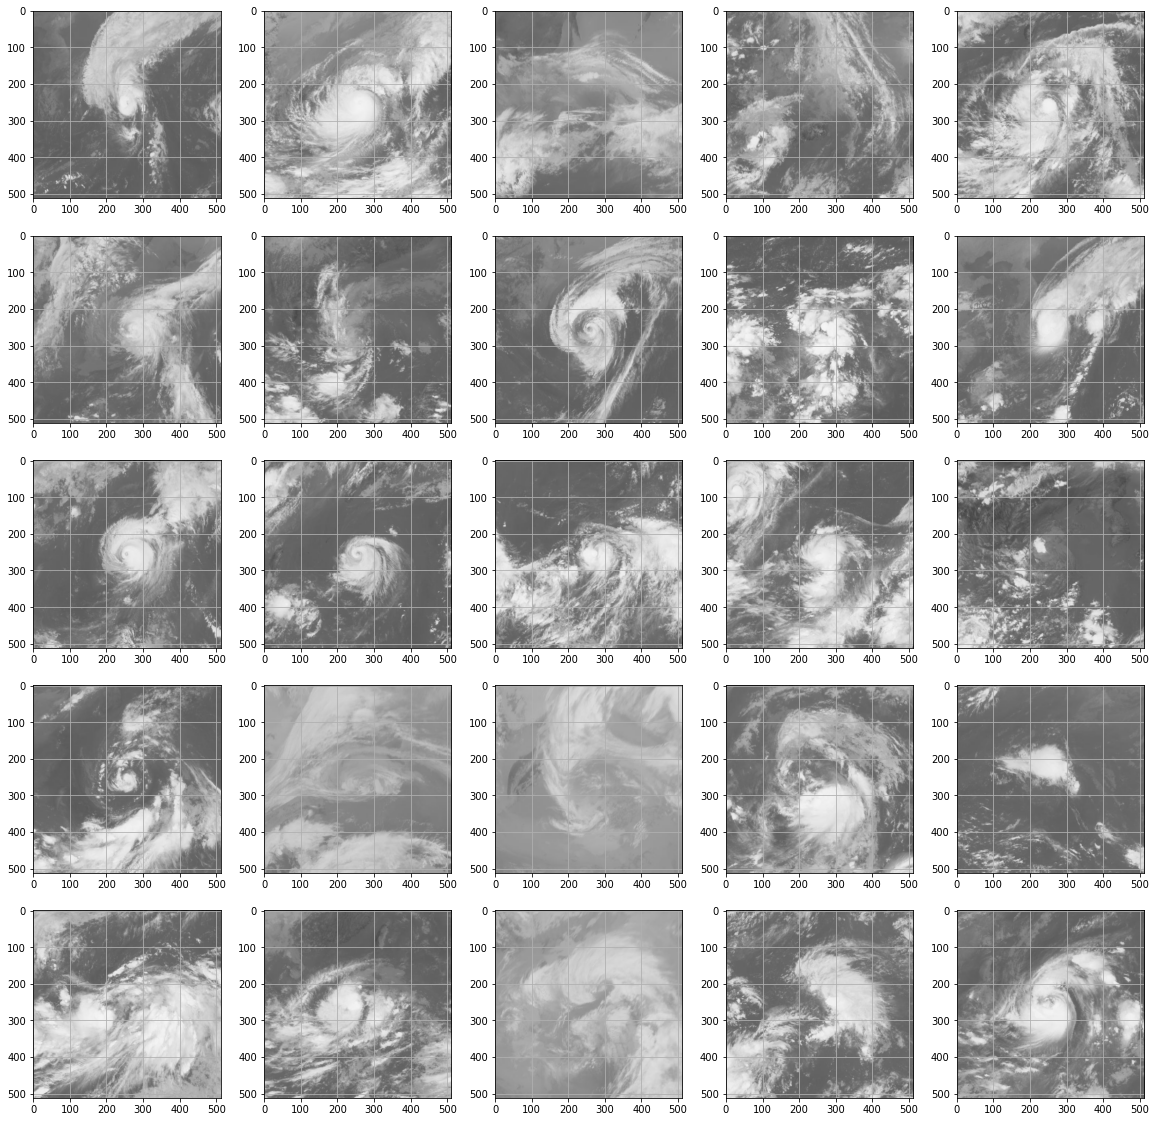

In [ ]:
## image visualization
plt.rcParams['figure.figsize'] = (20, 20)
f, ax = plt.subplots(ncols=5, nrows=5)

for i in range(5):
    for j in range(5):
        image = image_array[np.random.randint(0, len(image_array))]
        ax[i,j].imshow(image)
        ax[i,j].grid()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, LSTM, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, TimeDistributed
from keras import Input, Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.models import load_model, model_from_json

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [ ]:
datagen_all = ImageDataGenerator(rescale=1/255)
dat_gen_cat = datagen_all.flow_from_dataframe(
                                dataframe=track_df, directory="./Image/", 
                                x_col="filename", y_col="category", 
                                class_mode=None, target_size=(512, 512), 
                                batch_size=1, shuffle=False)
dat_gen_pre = datagen_all.flow_from_dataframe(
                                dataframe=track_df, directory="./Image/", 
                                x_col="filename", y_col="pressure", 
                                class_mode=None, target_size=(512, 512), 
                                batch_size=1, shuffle=False)

Found 9150 validated image filenames.
Found 9150 validated image filenames.


In [ ]:
train_generator_category = datagen.flow_from_dataframe(
                                dataframe=track_df, directory="./Image/", 
                                x_col="filename", y_col="category", 
                                class_mode="sparse", target_size=(512, 512), 
                                batch_size=8, subset="training")
val_generator_category = datagen.flow_from_dataframe(
                                dataframe=track_df, directory="./Image/", 
                                x_col="filename", y_col="category", 
                                class_mode="sparse", target_size=(512, 512), 
                                batch_size=8, subset="validation")

Found 7320 validated image filenames belonging to 5 classes.
Found 1830 validated image filenames belonging to 5 classes.


In [ ]:
train_generator_pressure = datagen.flow_from_dataframe(
                                dataframe=track_df, directory="./Image/", 
                                x_col="filename", y_col="pressure", 
                                class_mode="raw", target_size=(512, 512), 
                                batch_size=8, subset="training")
val_generator_pressure = datagen.flow_from_dataframe(
                                dataframe=track_df, directory="./Image/", 
                                x_col="filename", y_col="pressure", 
                                class_mode="raw", target_size=(512, 512), 
                                batch_size=8, subset="validation")

Found 7320 validated image filenames.
Found 1830 validated image filenames.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.utils import class_weight

In [ ]:
## pretrain a CNN
def CNN():

    input_x = Input(shape=(512,512,3))
    cnn_0 = Conv2D(8, (3,3), padding='same', activation='relu')(input_x)
    max_pool_0 = MaxPooling2D(pool_size=(2,2))(cnn_0)
    cnn_1 = Conv2D(16, (3,3), padding='same', activation='relu')(max_pool_0)
    bn_1 = BatchNormalization()(cnn_1)
    max_pool_1 = MaxPooling2D(pool_size=(2,2))(bn_1)
    cnn_2 = Conv2D(32, (3,3), padding='same', activation='relu')(max_pool_1)
    bn_2 = BatchNormalization()(cnn_2)
    max_pool_2 = MaxPooling2D(pool_size=(2,2))(bn_2)
    cnn_3 = Conv2D(64, (3,3), padding='same', activation='relu')(max_pool_2)
    bn_3 = BatchNormalization()(cnn_3)
    max_pool_3 = MaxPooling2D(pool_size=(2,2))(bn_3)
    cnn_4 = Conv2D(128, (3,3), padding='same', activation='relu')(max_pool_3)
    bn_4 = BatchNormalization()(cnn_4)
    max_pool_4 = MaxPooling2D(pool_size=(2,2))(bn_4)
    cnn_5 = Conv2D(256, (3,3), padding='same', activation='relu')(max_pool_4)
    bn_5 = BatchNormalization()(cnn_5)
    max_pool_5 = MaxPooling2D(pool_size=(2,2))(bn_5)
    cnn_6 = Conv2D(512, (3,3), padding='same', activation='relu')(max_pool_5)
    bn_6 = BatchNormalization()(cnn_6)
    max_pool_6 = MaxPooling2D(pool_size=(2,2))(bn_6)

    flatten = Flatten()(max_pool_6)

    dense_1 = Dense(512, activation='relu')(flatten)
    drop_1 = Dropout(0.2)(dense_1)
    dense_2 = Dense(32, activation='relu')(drop_1)

    return input_x, dense_2

input_x1, dense_c = CNN()
input_x2, dense_p = CNN()

output_y1 = Dense(5, activation='softmax')(dense_c)
output_y2 = Dense(1, activation='linear')(dense_p)

model_y1 = Model(inputs = input_x1, outputs = output_y1)
model_y2 = Model(inputs = input_x2, outputs = output_y2)

adam = Adam(learning_rate=1e-5)

model_y1.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
model_y2.compile(loss='mse', optimizer=adam, metrics = ['mae'])

In [ ]:
model_y1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      4640

In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(track_df['category']), 
                track_df['category'])

In [ ]:
## train on predicting the intensity category of next timesteps
model_y1.fit_generator(train_generator_category, epochs=30,
                       steps_per_epoch = train_generator_category.samples // 8,
                       validation_data = val_generator_category,
                       validation_steps = val_generator_category.samples // 8,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                       class_weight={0:class_weights[0], 1:class_weights[1],
                                     2:class_weights[2], 3:class_weights[3],
                                     4:class_weights[4], 5:class_weights[5]})

Epoch 1/30
915/915 [==============================] - 51s 55ms/step - loss: 1.2304 - accuracy: 0.4913 - val_loss: 1.1876 - val_accuracy: 0.4868
Epoch 2/30
915/915 [==============================] - 49s 54ms/step - loss: 0.9596 - accuracy: 0.5966 - val_loss: 1.2147 - val_accuracy: 0.5351
Epoch 3/30
915/915 [==============================] - 49s 53ms/step - loss: 0.8041 - accuracy: 0.6682 - val_loss: 1.4349 - val_accuracy: 0.5324
Epoch 4/30
915/915 [==============================] - 49s 54ms/step - loss: 0.6733 - accuracy: 0.7275 - val_loss: 1.0747 - val_accuracy: 0.5521
Epoch 5/30
915/915 [==============================] - 49s 53ms/step - loss: 0.5460 - accuracy: 0.7949 - val_loss: 0.9953 - val_accuracy: 0.5439
Epoch 6/30
915/915 [==============================] - 49s 53ms/step - loss: 0.4510 - accuracy: 0.8347 - val_loss: 1.3451 - val_accuracy: 0.5417
Epoch 7/30
915/915 [==============================] - 49s 53ms/step - loss: 0.3441 - accuracy: 0.8811 - val_loss: 0.6673 - val_accuracy:

In [ ]:
pred_all_1 = model_y1.predict_generator(dat_gen_cat)

              precision    recall  f1-score   support

           2       0.93      0.91      0.92      2284
           3       0.84      0.90      0.87      2150
           4       0.89      0.80      0.84      1285
           5       0.94      0.94      0.94      2395
           6       0.96      0.98      0.97      1036

    accuracy                           0.91      9150
   macro avg       0.91      0.91      0.91      9150
weighted avg       0.91      0.91      0.91      9150



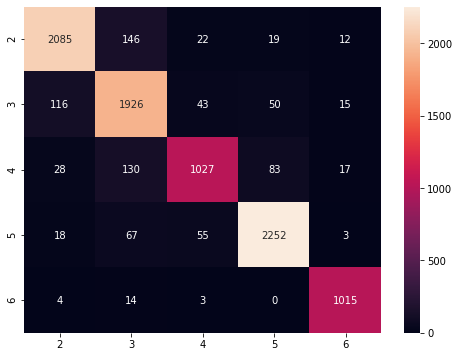

In [ ]:
print(classification_report([int(x) for x in track_df['category']], 
                            [np.argmax(pred_all_1[x])+2 for x in range(len(pred_all_1))]))

plt.rcParams['figure.figsize'] = (8, 6)
seaborn.heatmap(confusion_matrix([int(x) for x in track_df['category']], 
                                 [np.argmax(pred_all_1[x])+2 for x in range(len(pred_all_1))]),
                annot=True, fmt="d", xticklabels=[2,3,4,5,6], yticklabels=[2,3,4,5,6])

In [ ]:
## train on predicting the air pressure of next timesteps
model_y2.fit_generator(train_generator_pressure, epochs=10,
                       steps_per_epoch = train_generator_pressure.samples // 8,
                       validation_data = val_generator_pressure,
                       validation_steps = val_generator_pressure.samples // 8,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
915/915 [==============================] - 50s 54ms/step - loss: 58900.8400 - mae: 121.1377 - val_loss: 793.1096 - val_mae: 24.3213
Epoch 2/10
915/915 [==============================] - 49s 53ms/step - loss: 2075.7453 - mae: 36.1169 - val_loss: 1019.5903 - val_mae: 19.2824
Epoch 3/10
915/915 [==============================] - 48s 52ms/step - loss: 1910.1237 - mae: 34.7698 - val_loss: 381.7738 - val_mae: 21.3392
Epoch 4/10
915/915 [==============================] - 49s 53ms/step - loss: 1720.5918 - mae: 33.1186 - val_loss: 1967.9478 - val_mae: 40.9476
Epoch 5/10
915/915 [==============================] - 49s 54ms/step - loss: 1617.8060 - mae: 31.9825 - val_loss: 211.8470 - val_mae: 17.0406
Epoch 6/10
915/915 [==============================] - 49s 53ms/step - loss: 1535.9962 - mae: 31.0498 - val_loss: 452.8580 - val_mae: 17.0422
Epoch 7/10
915/915 [==============================] - 48s 52ms/step - loss: 1490.3239 - mae: 30.8219 - val_loss: 282.0455 - val_mae: 16.2927
Epoch 8/1

In [ ]:
pred_all_2 = model_y2.predict_generator(dat_gen_pre)

In [ ]:
mean_absolute_error(track_df['pressure'], pred_all_2)

13.901719903998035

In [ ]:
feature_ext_y1 = Model(inputs=model_y1.input,
                       outputs=model_y1.get_layer(model_y1.layers[-5].name).output)

In [ ]:
feature_wind_category = feature_ext_y1.predict_generator(dat_gen_cat)

In [ ]:
feature_wind_category.shape

(9150, 8192)

In [ ]:
feature_ext_y2 = Model(inputs=model_y2.input,
                       outputs=model_y2.get_layer(model_y2.layers[-5].name).output)

In [ ]:
feature_pressure = feature_ext_y2.predict_generator(dat_gen_pre)

In [ ]:
feature_pressure.shape

(9150, 8192)

In [ ]:
## generate list of index per typhoon
list_timestep = []
sublist_timestep = [0]
for t in range(1, len(track_df)):
    if track_df['timestep'][t] == 0:
        list_timestep.append(sublist_timestep)
        sublist_timestep = []
    sublist_timestep.append(t)
list_timestep.append(sublist_timestep)

In [ ]:
## pad 5 negative values at the end to separate the timespace between each typhoon
for y in range(len(list_timestep)):
    list_timestep[y] = list_timestep[y] + [-1, -1, -1, -1, -1]

In [ ]:
## re-stack into 1d list of padded indices
pad_index = [x for y in list_timestep for x in y]

In [ ]:
## 5 lags as features to predict the next observation of the target
feature_index = [pad_index[n:n+5] for n in range(len(pad_index)-(5-1))]

In [ ]:
feature_index[0:25]

[[0, 1, 2, 3, 4],
 [1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6],
 [3, 4, 5, 6, 7],
 [4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9],
 [6, 7, 8, 9, 10],
 [7, 8, 9, 10, 11],
 [8, 9, 10, 11, 12],
 [9, 10, 11, 12, 13],
 [10, 11, 12, 13, 14],
 [11, 12, 13, 14, 15],
 [12, 13, 14, 15, 16],
 [13, 14, 15, 16, -1],
 [14, 15, 16, -1, -1],
 [15, 16, -1, -1, -1],
 [16, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1],
 [-1, -1, -1, -1, 17],
 [-1, -1, -1, 17, 18],
 [-1, -1, 17, 18, 19],
 [-1, 17, 18, 19, 20],
 [17, 18, 19, 20, 21],
 [18, 19, 20, 21, 22],
 [19, 20, 21, 22, 23]]

In [ ]:
feature_index[-25:]

[[9126, 9127, 9128, 9129, 9130],
 [9127, 9128, 9129, 9130, 9131],
 [9128, 9129, 9130, 9131, 9132],
 [9129, 9130, 9131, 9132, 9133],
 [9130, 9131, 9132, 9133, 9134],
 [9131, 9132, 9133, 9134, 9135],
 [9132, 9133, 9134, 9135, 9136],
 [9133, 9134, 9135, 9136, 9137],
 [9134, 9135, 9136, 9137, 9138],
 [9135, 9136, 9137, 9138, 9139],
 [9136, 9137, 9138, 9139, 9140],
 [9137, 9138, 9139, 9140, 9141],
 [9138, 9139, 9140, 9141, 9142],
 [9139, 9140, 9141, 9142, 9143],
 [9140, 9141, 9142, 9143, 9144],
 [9141, 9142, 9143, 9144, 9145],
 [9142, 9143, 9144, 9145, 9146],
 [9143, 9144, 9145, 9146, 9147],
 [9144, 9145, 9146, 9147, 9148],
 [9145, 9146, 9147, 9148, 9149],
 [9146, 9147, 9148, 9149, -1],
 [9147, 9148, 9149, -1, -1],
 [9148, 9149, -1, -1, -1],
 [9149, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1]]

In [ ]:
## taking 5 lags for predictions of observations in t + 1; padding last 5 as an ending value
def pad_target(default, target_col):
    pad_target = []
    for t in range(len(feature_index) - 1):
        if -1 in feature_index[t]:
            pad_target.append(default)
        elif -1 in feature_index[t+1]:
            pad_target.append(default)
        else:
            pad_target.append(target_col[feature_index[t][-1] + 1])
    
    return pad_target

In [ ]:
## get targets for predictions with defaulted values

pad_target_cat = pad_target(0, [int(x) for x in track_df['category']])
pad_target_pre = pad_target(1000, [float(x) for x in track_df['pressure']])
pad_target_wind = pad_target(0, [float(x) for x in track_df['wind']])
pad_target_lat = pad_target(75, [x for x in track_df['latitude']])
pad_target_lon = pad_target(0, [x for x in track_df['longitude']])

In [ ]:
pad_target_pre = np.array(pad_target_pre)
pad_target_wind = np.array(pad_target_wind)
pad_target_lat = np.array(pad_target_lat)
pad_target_lon = np.array(pad_target_lon)

In [ ]:
## map CNN outputted 8192 dimensional vectors for each index position, padded -1 using a zero vector
def fetch_trained_CNN_feature_vec(feature_array):
    x_array = np.zeros((len(feature_index) - 1, 5, 8192))
    for t in range(len(feature_index) - 1):
        for p in range(5):
            if feature_index[t][p] != -1:
                x_array[t][p] = feature_array[feature_index[t][p]]
    return x_array

In [ ]:
feature_vector_wind_cat = fetch_trained_CNN_feature_vec(feature_wind_category)

In [ ]:
feature_vector_wind_cat.shape

(10405, 5, 8192)

In [ ]:
feature_vector_pre = fetch_trained_CNN_feature_vec(feature_pressure)

In [ ]:
feature_vector_pre.shape

(10405, 5, 8192)

In [ ]:
## one-hot encoded arrays for neural network training inputs
from sklearn.preprocessing import OneHotEncoder
pad_target_oh = OneHotEncoder().fit_transform(np.array(pad_target_cat).reshape(-1, 1)).toarray()

In [ ]:
pad_target_oh.shape

(10405, 6)

<ol>
<li>LSTM with only CNN image feature vectors:
<ul>
<li> Intensity Category: accuracy = 65%; </li>
<li> Wind Speed: mean absoulte error = 9.01479; </li>
<li> Air Pressure: mean absoulte error = 7.50046; </li>
</ul>
The extracted image features were not quite successful in predicting the changes in intensity category, as shown the overall accuracy dropped to 65%. There was a large inter-class variation on the predictive performances. On class 0 and class 5, it got F1-scores of 84% and 80%, and 66% on class 6, but for the remaining classes, the F1-scores were below 50%. 

Referring to the confusion matrix, most misclassifications of class 6 were actually class 0, and this was not practically important because class 6 marked a typhoon was at its final stage weakening until fully dissipated. The model just could not get the right time when the typhoon was regarded as dead for this case. The more worth-noting point would be for classes 2 to 4, the model could not ideally capture the transition timing of a typhoon from category 2 to category 3, and it was confused to identify when a typhoon was at category 4. The reason behind was probably due to the strengthening process of a strong typhoon was usually fast or even drastic within 12 to 24 hours. After attaining the strongest level, category 5, the typhoon would be likely to maintain this intensity until landfall, so it got a high accuracy on category 5.

However, it was found that if the target for the LSTM was changed from the categorical intensity to the continuous wind speed, the performance could be improved. With the 8192-dimension image features, the MAE obtained on wind speed was 9.015 kt, given that the ranges of the difference in wind speed for transitions between consecutive intensity categories would be around 13 kt to 21 kt, the MAE achieved seems not bad in this perspective. 
</li>

<li>LSTM with only the 4 tracking physical features (wind speed, air pressure, latitude, longitude):
<ul>
<li> Intensity Category: accuracy = 86%; </li>
<li> Wind Speed: mean absoulte error = 4.83381; </li>
<li> Air Pressure: mean absoulte error = 4.69169; </li>
</ul>

Using the tracked geolocations and wind and pressure data, the accuracy of the 6-hour forecast on the wind intensity category increased from 65% to 86%, and the error of forecsating the maximum wind speed and central atmospheric pressure decreased by 46.4% and 37.4% respectively. These results would serve as the benchmarks for testing the models trained with combined image-driven latent features and the 4 tracking features.
</li>

<li>LSTM with combined CNN image feature vectors + 4 tracking physical features

<ul>
<li> Intensity Category: accuracy = 87%; </li>
<li> Wind Speed: mean absoulte error = 3.86617; </li>
<li> Air Pressure: mean absoulte error = 3.64178; </li>
</ul>

The model with combined features outweighed the individual models with purely image feature inputs or purely tracking feature inputs. For the wind intensity category, after adding the image features, the recall rate (correctly capturing positives) of category 2 increased from 0.76 to 0.88 and the precision (correctly inferring positives) of category 6 increased from 0.68 to 0.85 for the same set of testing data. The overall accuracy increased 1%, while weighted average of precision, recall and f1-score increased by 2%. For the MAEs on forecasting 6-hour wind speed and atmospheric pressure in the storm system, the combined-feature model respectively reduced by 20.0% and 22.4% compared to LSTM with 4 tracking features. 

This could bring to a preliminary conclusion such that the physical monitored metrics still acted the determining roles in predicting observations in future timesteps, while the satellite images could be a supplementary element that improved the forecasting accuracy. Although at the moment it might not be powerful enough to exactly align with the same levels of accuracy given by the physical simulation models or sophisticated computations, it might support the refining process of typhoon forecasting as being one of the components of a more all-rounded ensemble or pipeline of forecasting models.
</li>


In [ ]:
## splitting 20% testing data
train_X, train_y, val_X, val_y, test_X, test_y = \
        feature_vector_wind_cat[0:int(len(feature_vector_wind_cat)*0.7)], \
        pad_target_oh[0:int(len(pad_target_oh)*0.7)], \
        feature_vector_wind_cat[int(len(feature_vector_wind_cat)*0.7):int(len(feature_vector_wind_cat)*0.8)], \
        pad_target_oh[int(len(pad_target_oh)*0.7):int(len(pad_target_oh)*0.8)], \
        feature_vector_wind_cat[int(len(feature_vector_wind_cat)*0.8):], \
        pad_target_oh[int(len(pad_target_oh)*0.8):]

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(7283, 5, 8192)
(7283, 6)
(1041, 5, 8192)
(1041, 6)
(2081, 5, 8192)
(2081, 6)


In [ ]:
def LSTM_from_CNN_features():
  
    input_cnn = Input(shape=(5, 8192))
    lstm_1 = LSTM(1024, return_sequences=True)(input_cnn)
    lstm_2 = LSTM(256)(lstm_1)
    dense_1 = Dense(50, activation='relu')(lstm_2)

    return input_cnn, dense_1

input_cnn_1, dense_c_l = LSTM_from_CNN_features()
input_cnn_2, dense_p_l = LSTM_from_CNN_features()

output_1 = Dense(6, activation='softmax')(dense_c_l)
output_2 = Dense(1, activation='linear')(dense_p_l)

optim1 = Adam(lr=1e-5)
optim2 = Adam(lr=1e-4)

lstm_wind_category = Model(inputs = input_cnn_1, outputs = output_1)
lstm_wind_category.compile(loss='categorical_crossentropy', optimizer=optim1, metrics=['accuracy'])
lstm_pressure = Model(inputs = input_cnn_2, outputs = output_2)
lstm_pressure.compile(loss='mse', optimizer=optim2, metrics=['mae'])

In [ ]:
lstm_wind_category.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 5, 8192)           0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 5, 1024)           37752832  
_________________________________________________________________
lstm_47 (LSTM)               (None, 256)               1311744   
_________________________________________________________________
dense_38 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 306       
Total params: 39,077,732
Trainable params: 39,077,732
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(pad_target_cat), 
                pad_target_cat)

In [ ]:
lstm_wind_category.fit(train_X, train_y, batch_size=1, epochs=30,
                      validation_data=[val_X, val_y],
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                      class_weight={0:class_weights[0], 1:class_weights[1],
                                    2:class_weights[2], 3:class_weights[3],
                                    4:class_weights[4], 5:class_weights[5]})

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 65s 9ms/step - loss: 31.2934 - accuracy: 0.3179 - val_loss: 10.4276 - val_accuracy: 0.4361
Epoch 2/30
7283/7283 [==============================] - 63s 9ms/step - loss: 4.3804 - accuracy: 0.5683 - val_loss: 2.2734 - val_accuracy: 0.4966
Epoch 3/30
7283/7283 [==============================] - 63s 9ms/step - loss: 1.2860 - accuracy: 0.7564 - val_loss: 1.1304 - val_accuracy: 0.6513
Epoch 4/30
7283/7283 [==============================] - 64s 9ms/step - loss: 0.4745 - accuracy: 0.8834 - val_loss: 0.9058 - val_accuracy: 0.6551
Epoch 5/30
7283/7283 [==============================] - 63s 9ms/step - loss: 0.2556 - accuracy: 0.9333 - val_loss: 0.8705 - val_accuracy: 0.6888
Epoch 6/30
7283/7283 [==============================] - 63s 9ms/step - loss: 0.1451 - accuracy: 0.9595 - val_loss: 0.9554 - val_accuracy: 0.6705
Epoch 7/30
7283/7283 [==============================] - 63s 9ms/step - loss: 0.0

In [ ]:
lstm_wind_category_pred = lstm_wind_category.predict(test_X, batch_size=1)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       485
           2       0.57      0.25      0.34       299
           3       0.43      0.57      0.49       375
           4       0.41      0.26      0.32       213
           5       0.73      0.88      0.80       511
           6       0.78      0.57      0.66       198

    accuracy                           0.65      2081
   macro avg       0.62      0.57      0.58      2081
weighted avg       0.64      0.65      0.63      2081



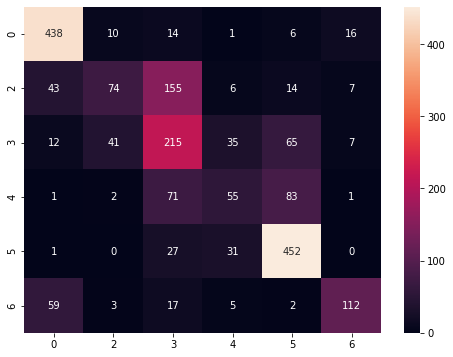

In [ ]:
print(classification_report([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in test_y], 
                            [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in lstm_wind_category_pred]))

plt.rcParams['figure.figsize'] = (8, 6)
seaborn.heatmap(confusion_matrix([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in test_y], 
                                 [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in lstm_wind_category_pred]),
                annot=True, fmt="d", xticklabels=[0,2,3,4,5,6], yticklabels=[0,2,3,4,5,6])

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = \
        feature_vector_wind_cat[0:int(len(feature_vector_wind_cat)*0.7)], \
        pad_target_wind[0:int(len(pad_target_wind)*0.7)], \
        feature_vector_wind_cat[int(len(feature_vector_wind_cat)*0.7):int(len(feature_vector_wind_cat)*0.8)], \
        pad_target_wind[int(len(pad_target_wind)*0.7):int(len(pad_target_wind)*0.8)], \
        feature_vector_wind_cat[int(len(feature_vector_wind_cat)*0.8):], \
        pad_target_wind[int(len(pad_target_wind)*0.8):]

input_cnn_3, dense_w_l = LSTM_from_CNN_features()
output_3 = Dense(1, activation='linear')(dense_w_l)

lstm_wind = Model(inputs = input_cnn_3, outputs = output_3)
lstm_wind.compile(loss='mse', optimizer=optim2, metrics=['mae'])

In [ ]:
lstm_wind.fit(train_X, train_y, batch_size=1, epochs=30,
                  validation_data=[val_X, val_y],
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 72s 10ms/step - loss: 432.5863 - mae: 14.1939 - val_loss: 244.4108 - val_mae: 11.1246
Epoch 2/30
7283/7283 [==============================] - 71s 10ms/step - loss: 136.8206 - mae: 7.5279 - val_loss: 224.3226 - val_mae: 9.3063
Epoch 3/30
7283/7283 [==============================] - 71s 10ms/step - loss: 79.0197 - mae: 5.3889 - val_loss: 224.9018 - val_mae: 9.9729
Epoch 4/30
7283/7283 [==============================] - 71s 10ms/step - loss: 57.2588 - mae: 4.5014 - val_loss: 208.6501 - val_mae: 8.8021
Epoch 5/30
7283/7283 [==============================] - 71s 10ms/step - loss: 46.0683 - mae: 3.9914 - val_loss: 224.4734 - val_mae: 9.4995
Epoch 6/30
7283/7283 [==============================] - 70s 10ms/step - loss: 35.1563 - mae: 3.4715 - val_loss: 221.6109 - val_mae: 9.3835
Epoch 7/30
7283/7283 [==============================] - 70s 10ms/step - loss: 30.2338 - mae: 3.2189 - val_loss: 24

In [ ]:
lstm_wind_pred = lstm_wind.predict(test_X, batch_size=1)

In [ ]:
mean_absolute_error(test_y, lstm_wind_pred)

9.014791750791717

In [ ]:
train_X2, train_y2, val_X2, val_y2, test_X2, test_y2 = \
        feacture_vector_pre[0:int(len(feacture_vector_pre)*0.7)], \
        pad_target_pre[0:int(len(pad_target_pre)*0.7)], \
        feacture_vector_pre[int(len(feacture_vector_pre)*0.7):int(len(feacture_vector_pre)*0.8)], \
        pad_target_pre[int(len(pad_target_pre)*0.7):int(len(pad_target_pre)*0.8)], \
        feacture_vector_pre[int(len(feacture_vector_pre)*0.8):], \
        pad_target_pre[int(len(pad_target_pre)*0.8):]

In [ ]:
lstm_pressure.fit(train_X2, train_y2, batch_size=1, epochs=30,
                  validation_data=[val_X2, val_y2],
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 69s 9ms/step - loss: 639512.1920 - mae: 788.1589 - val_loss: 282710.3968 - val_mae: 531.3696
Epoch 2/30
7283/7283 [==============================] - 68s 9ms/step - loss: 85818.9660 - mae: 256.1201 - val_loss: 3994.2066 - val_mae: 60.6240
Epoch 3/30
7283/7283 [==============================] - 68s 9ms/step - loss: 873.6359 - mae: 24.3455 - val_loss: 371.8345 - val_mae: 16.0041
Epoch 4/30
7283/7283 [==============================] - 68s 9ms/step - loss: 522.5756 - mae: 18.0623 - val_loss: 383.8073 - val_mae: 16.6501
Epoch 5/30
7283/7283 [==============================] - 68s 9ms/step - loss: 523.0095 - mae: 18.1299 - val_loss: 367.7579 - val_mae: 15.7708
Epoch 6/30
7283/7283 [==============================] - 67s 9ms/step - loss: 523.0819 - mae: 18.0727 - val_loss: 404.3712 - val_mae: 17.4907
Epoch 7/30
7283/7283 [==============================] - 68s 9ms/step - loss: 513.8903 - mae: 1

In [ ]:
lstm_pressure_pred = lstm_pressure.predict(test_X2, batch_size=1)

In [ ]:
mean_absolute_error(test_y2, lstm_pressure_pred)

7.500458834206811

In [ ]:
## LSTM with wind, pressure, coordinates as time-series features
## get features by time index
def fetch_4_tranking_features_vec(feature_array):
    x_array = np.zeros((len(feature_index) - 1, 5, 4))
    for t in range(len(feature_index) - 1):
        for p in range(5):
            if feature_index[t][p] != -1:
                x_array[t][p] = feature_array[feature_index[t][p]]
    return x_array

In [ ]:
feature_vector_track_4 = fetch_4_tranking_features_vec(np.array(track_df[['wind','pressure','latitude','longitude']]))

In [ ]:
feature_vector_track_4.shape

(10405, 5, 4)

In [ ]:
feature_vector_w = np.concatenate((feature_vector_wind_cat, feature_vector_track_4), axis=2)

In [ ]:
feature_vector_w.shape

(10405, 5, 8196)

In [ ]:
feature_vector_p = np.concatenate((feature_vector_pre, feature_vector_track_4), axis=2)

In [ ]:
feature_vector_p.shape

(10405, 5, 8196)

In [ ]:
def LSTM_from_4_Tracking_features():

    input_x = Input(shape=(5, 4))
    lstm_1 = LSTM(1024, return_sequences=True)(input_x)
    lstm_2 = LSTM(256)(lstm_1)
    dense_1 = Dense(50, activation='relu')(lstm_2)
    
    return input_x, dense_1

input_wc_x, dense_wc = LSTM_from_4_Tracking_features()
input_w_x, dense_w = LSTM_from_4_Tracking_features()
input_p_x, dense_p = LSTM_from_4_Tracking_features()

output_wc = Dense(6, activation='softmax')(dense_wc)
output_w = Dense(1, activation='linear')(dense_w)
output_p = Dense(1, activation='linear')(dense_p)

optim1 = Adam(lr=1e-5)
optim2 = Adam(lr=1e-4)

lstm_w_cat = Model(inputs = input_wc_x, outputs = output_wc)
lstm_w_cat.compile(loss='categorical_crossentropy', optimizer=optim2, metrics=['accuracy'])
lstm_w = Model(inputs = input_w_x, outputs = output_w)
lstm_w.compile(loss='mse', optimizer=optim2, metrics=['mae'])
lstm_p = Model(inputs = input_p_x, outputs = output_p)
lstm_p.compile(loss='mse', optimizer=optim2, metrics=['mae'])

In [ ]:
train_X3, train_y3, val_X3, val_y3, test_X3, test_y3 = \
        feature_vector_track_4[0:int(len(feature_vector_track_4)*0.7)], \
        pad_target_oh[0:int(len(pad_target_oh)*0.7)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.7):int(len(feature_vector_track_4)*0.8)], \
        pad_target_oh[int(len(pad_target_oh)*0.7):int(len(pad_target_oh)*0.8)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.8):], \
        pad_target_oh[int(len(pad_target_oh)*0.8):]

In [ ]:
lstm_w_cat.fit(train_X3, train_y3, batch_size=1, epochs=30,
              validation_data=(val_X3, val_y3),
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
              class_weight={0:class_weights[0], 1:class_weights[1],
                            2:class_weights[2], 3:class_weights[3],
                            4:class_weights[4], 5:class_weights[5]})

Epoch 1/30
7283/7283 [==============================] - 48s 6ms/step - loss: 0.8962 - accuracy: 0.6750 - val_loss: 0.5515 - val_accuracy: 0.7771
Epoch 2/30
7283/7283 [==============================] - 46s 6ms/step - loss: 0.4840 - accuracy: 0.8352 - val_loss: 0.4022 - val_accuracy: 0.8703
Epoch 3/30
7283/7283 [==============================] - 45s 6ms/step - loss: 0.4602 - accuracy: 0.8376 - val_loss: 0.3704 - val_accuracy: 0.8818
Epoch 4/30
7283/7283 [==============================] - 46s 6ms/step - loss: 0.4554 - accuracy: 0.8440 - val_loss: 0.3596 - val_accuracy: 0.8684
Epoch 5/30
7283/7283 [==============================] - 46s 6ms/step - loss: 0.4210 - accuracy: 0.8496 - val_loss: 0.3504 - val_accuracy: 0.8751
Epoch 6/30
7283/7283 [==============================] - 45s 6ms/step - loss: 0.4146 - accuracy: 0.8484 - val_loss: 0.3538 - val_accuracy: 0.8713
Epoch 7/30
7283/7283 [==============================] - 46s 6ms/step - loss: 0.4105 - accuracy: 0.8546 - val_loss: 0.3557 - val_ac

In [ ]:
lstm_w_cat_pred = lstm_w_cat.predict(test_X3, batch_size=1)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       485
           2       0.78      0.76      0.77       299
           3       0.82      0.86      0.84       375
           4       0.69      0.80      0.74       213
           5       0.99      0.88      0.93       511
           6       0.68      0.88      0.77       198

    accuracy                           0.86      2081
   macro avg       0.83      0.85      0.83      2081
weighted avg       0.87      0.86      0.86      2081



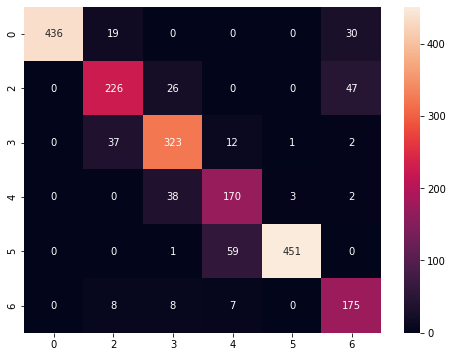

In [ ]:
print(classification_report([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in test_y3], 
                            [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in lstm_w_cat_pred]))

plt.rcParams['figure.figsize'] = (8, 6)
seaborn.heatmap(confusion_matrix([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in test_y3], 
                                 [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in lstm_w_cat_pred]),
                annot=True, fmt="d", xticklabels=[0,2,3,4,5,6], yticklabels=[0,2,3,4,5,6])

In [ ]:
train_X3, train_y3, val_X3, val_y3, test_X3, test_y3 = \
        feature_vector_track_4[0:int(len(feature_vector_track_4)*0.7)], \
        pad_target_wind[0:int(len(pad_target_wind)*0.7)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.7):int(len(feature_vector_track_4)*0.8)], \
        pad_target_wind[int(len(pad_target_wind)*0.7):int(len(pad_target_wind)*0.8)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.8):], \
        pad_target_wind[int(len(pad_target_wind)*0.8):]

train_X4, train_y4, val_X4, val_y4, test_X4, test_y4 = \
        feature_vector_track_4[0:int(len(feature_vector_track_4)*0.7)], \
        pad_target_pre[0:int(len(pad_target_pre)*0.7)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.7):int(len(feature_vector_track_4)*0.8)], \
        pad_target_pre[int(len(pad_target_pre)*0.7):int(len(pad_target_pre)*0.8)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.8):], \
        pad_target_pre[int(len(pad_target_pre)*0.8):]

In [ ]:
lstm_w.fit(train_X3, train_y3, batch_size=1, epochs=30,
              validation_data=[val_X3, val_y3],
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 68s 9ms/step - loss: 437.6394 - mae: 13.4729 - val_loss: 116.8117 - val_mae: 6.8860
Epoch 2/30
7283/7283 [==============================] - 66s 9ms/step - loss: 86.8525 - mae: 5.8575 - val_loss: 107.0288 - val_mae: 6.2968
Epoch 3/30
7283/7283 [==============================] - 67s 9ms/step - loss: 60.0579 - mae: 4.6724 - val_loss: 96.2782 - val_mae: 5.8376
Epoch 4/30
7283/7283 [==============================] - 67s 9ms/step - loss: 45.4483 - mae: 4.0839 - val_loss: 97.7400 - val_mae: 6.0028
Epoch 5/30
7283/7283 [==============================] - 67s 9ms/step - loss: 34.4133 - mae: 3.5759 - val_loss: 88.5757 - val_mae: 5.2773
Epoch 6/30
7283/7283 [==============================] - 67s 9ms/step - loss: 28.2156 - mae: 3.2435 - val_loss: 102.1662 - val_mae: 5.6970
Epoch 7/30
7283/7283 [==============================] - 66s 9ms/step - loss: 21.0868 - mae: 2.8261 - val_loss: 88.9917 - val_

In [ ]:
lstm_w_pred = lstm_w.predict(test_X3, batch_size=1)

In [ ]:
mean_absolute_error(test_y3, lstm_w_pred)

4.833806288648344

In [ ]:
lstm_p.fit(train_X4, train_y4, batch_size=1, epochs=30,
              validation_data=[val_X4, val_y4],
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 181s 25ms/step - loss: 343347.0696 - mae: 543.5802 - val_loss: 45176.3171 - val_mae: 211.7058
Epoch 2/30
7283/7283 [==============================] - 185s 25ms/step - loss: 7932.7748 - mae: 67.9556 - val_loss: 409.7037 - val_mae: 17.6698
Epoch 3/30
7283/7283 [==============================] - 182s 25ms/step - loss: 522.4886 - mae: 18.1926 - val_loss: 383.1809 - val_mae: 16.6218
Epoch 4/30
7283/7283 [==============================] - 178s 24ms/step - loss: 522.2405 - mae: 18.0999 - val_loss: 381.1357 - val_mae: 16.5268
Epoch 5/30
7283/7283 [==============================] - 179s 25ms/step - loss: 516.1941 - mae: 17.9720 - val_loss: 376.4800 - val_mae: 16.6154
Epoch 6/30
7283/7283 [==============================] - 180s 25ms/step - loss: 263.5239 - mae: 11.6089 - val_loss: 93.3999 - val_mae: 6.1891
Epoch 7/30
7283/7283 [==============================] - 180s 25ms/step - loss: 90.0850 -

In [ ]:
lstm_p_pred = lstm_p.predict(test_X4, batch_size=1)

In [ ]:
mean_absolute_error(test_y4, lstm_p_pred)

4.691689868433896

In [ ]:
def LSTM_from_combined():

    input_x = Input(shape=(5, 8196))
    lstm_1 = LSTM(1024, return_sequences=True)(input_x)
    lstm_2 = LSTM(256)(lstm_1)
    dense_1 = Dense(50, activation='relu')(lstm_2)

    return input_x, dense_1

optim1 = Adam(lr=1e-5)
optim2 = Adam(lr=1e-4)

input_wc_x2, dense_wc_2 = LSTM_from_combined()
input_w_x2, dense_w_2 = LSTM_from_combined()
input_p_x2, dense_p_2 = LSTM_from_combined()

output_wc2 = Dense(6, activation='softmax')(dense_wc_2)
output_w2 = Dense(1, activation='linear')(dense_w_2)
output_p2 = Dense(1, activation='linear')(dense_p_2)

lstm_w2_cat = Model(inputs = input_wc_x2, outputs = output_wc2)
lstm_w2_cat.compile(loss='categorical_crossentropy', optimizer=optim2, metrics=['accuracy'])
lstm_w2 = Model(inputs = input_w_x2, outputs = output_w2)
lstm_w2.compile(loss='mse', optimizer=optim2, metrics=['mae'])
lstm_p2 = Model(inputs = input_p_x2, outputs = output_p2)
lstm_p2.compile(loss='mse', optimizer=optim2, metrics=['mae'])

In [ ]:
train_X5, train_y5, val_X5, val_y5, test_X5, test_y5 = \
        feature_vector_w[0:int(len(feature_vector_w)*0.7)], \
        pad_target_oh[0:int(len(pad_target_oh)*0.7)], \
        feature_vector_w[int(len(feature_vector_w)*0.7):int(len(feature_vector_w)*0.8)], \
        pad_target_oh[int(len(pad_target_oh)*0.7):int(len(pad_target_oh)*0.8)], \
        feature_vector_w[int(len(feature_vector_w)*0.8):], \
        pad_target_oh[int(len(pad_target_oh)*0.8):]

In [ ]:
lstm_w2_cat.fit(train_X5, train_y5, batch_size=1, epochs=30,
              validation_data=(val_X5, val_y5),
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
              class_weight={0:class_weights[0], 1:class_weights[1],
                            2:class_weights[2], 3:class_weights[3],
                            4:class_weights[4], 5:class_weights[5]})

Epoch 1/30
7283/7283 [==============================] - 37s 5ms/step - loss: 0.8816 - accuracy: 0.6559 - val_loss: 0.5135 - val_accuracy: 0.8357
Epoch 2/30
7283/7283 [==============================] - 35s 5ms/step - loss: 0.4454 - accuracy: 0.8318 - val_loss: 0.4055 - val_accuracy: 0.8530
Epoch 3/30
7283/7283 [==============================] - 35s 5ms/step - loss: 0.3865 - accuracy: 0.8585 - val_loss: 0.3927 - val_accuracy: 0.8549
Epoch 4/30
7283/7283 [==============================] - 35s 5ms/step - loss: 0.3558 - accuracy: 0.8704 - val_loss: 0.4010 - val_accuracy: 0.8578
Epoch 5/30
7283/7283 [==============================] - 36s 5ms/step - loss: 0.3187 - accuracy: 0.8817 - val_loss: 0.4670 - val_accuracy: 0.8348
Epoch 6/30
7283/7283 [==============================] - 35s 5ms/step - loss: 0.3003 - accuracy: 0.8859 - val_loss: 0.4103 - val_accuracy: 0.8521


In [ ]:
lstm_w2_cat_pred = lstm_w2_cat.predict(test_X5, batch_size=1)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       485
           2       0.78      0.88      0.83       299
           3       0.83      0.84      0.84       375
           4       0.66      0.84      0.74       213
           5       0.98      0.88      0.93       511
           6       0.85      0.86      0.85       198

    accuracy                           0.87      2081
   macro avg       0.85      0.87      0.85      2081
weighted avg       0.88      0.87      0.87      2081



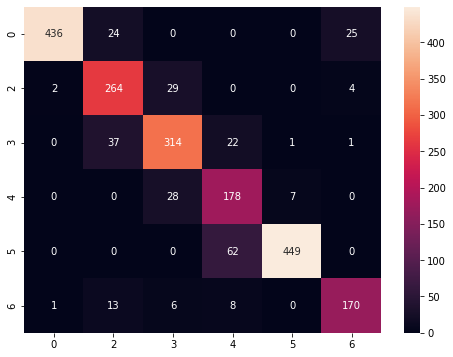

In [ ]:
print(classification_report([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in test_y5], 
                            [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in lstm_w2_cat_pred]))

plt.rcParams['figure.figsize'] = (8, 6)
seaborn.heatmap(confusion_matrix([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in test_y5], 
                                 [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in lstm_w2_cat_pred]),
                annot=True, fmt="d", xticklabels=[0,2,3,4,5,6], yticklabels=[0,2,3,4,5,6])

In [ ]:
train_X5, train_y5, val_X5, val_y5, test_X5, test_y5 = \
        feature_vector_w[0:int(len(feature_vector_w)*0.7)], \
        pad_target_wind[0:int(len(pad_target_wind)*0.7)], \
        feature_vector_w[int(len(feature_vector_w)*0.7):int(len(feature_vector_w)*0.8)], \
        pad_target_wind[int(len(pad_target_wind)*0.7):int(len(pad_target_wind)*0.8)], \
        feature_vector_w[int(len(feature_vector_w)*0.8):], \
        pad_target_wind[int(len(pad_target_wind)*0.8):]

train_X6, train_y6, val_X6, val_y6, test_X6, test_y6 = \
        feature_vector_p[0:int(len(feature_vector_p)*0.7)], \
        pad_target_pre[0:int(len(pad_target_pre)*0.7)], \
        feature_vector_p[int(len(feature_vector_p)*0.7):int(len(feature_vector_p)*0.8)], \
        pad_target_pre[int(len(pad_target_pre)*0.7):int(len(pad_target_pre)*0.8)], \
        feature_vector_p[int(len(feature_vector_p)*0.8):], \
        pad_target_pre[int(len(pad_target_pre)*0.8):]

In [ ]:
lstm_w2.fit(train_X5, train_y5, batch_size=1, epochs=30,
              validation_data=[val_X5, val_y5],
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 93s 13ms/step - loss: 350.0941 - mae: 10.5432 - val_loss: 105.0984 - val_mae: 6.2382
Epoch 2/30
7283/7283 [==============================] - 90s 12ms/step - loss: 68.6002 - mae: 4.5148 - val_loss: 72.8084 - val_mae: 4.6360
Epoch 3/30
7283/7283 [==============================] - 89s 12ms/step - loss: 64.0614 - mae: 4.2386 - val_loss: 68.7858 - val_mae: 4.0936
Epoch 4/30
7283/7283 [==============================] - 90s 12ms/step - loss: 61.9714 - mae: 4.1401 - val_loss: 62.3012 - val_mae: 3.9487
Epoch 5/30
7283/7283 [==============================] - 91s 13ms/step - loss: 60.2558 - mae: 4.0505 - val_loss: 64.9863 - val_mae: 4.7434
Epoch 6/30
7283/7283 [==============================] - 95s 13ms/step - loss: 60.4975 - mae: 4.0854 - val_loss: 66.0827 - val_mae: 3.8758
Epoch 7/30
7283/7283 [==============================] - 94s 13ms/step - loss: 59.9571 - mae: 4.0349 - val_loss: 60.4264 -

In [ ]:
lstm_w2_pred = lstm_w2.predict(test_X5, batch_size=1)

In [ ]:
mean_absolute_error(test_y5, lstm_w2_pred)

3.866167722371036

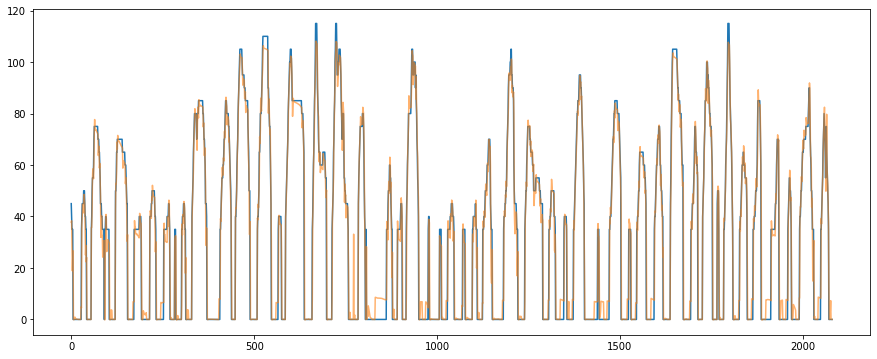

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(np.arange(0, len(test_y5)), test_y5)
plt.plot(np.arange(0, len(lstm_w2_pred)), lstm_w2_pred, alpha=0.6)

In [ ]:
lstm_p2.fit(train_X6, train_y6, batch_size=1, epochs=30,
              validation_data=[val_X6, val_y6],
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 97s 13ms/step - loss: 380154.2214 - mae: 579.3895 - val_loss: 61965.4630 - val_mae: 248.2110
Epoch 2/30
7283/7283 [==============================] - 95s 13ms/step - loss: 11652.5149 - mae: 83.4293 - val_loss: 439.5662 - val_mae: 18.5949
Epoch 3/30
7283/7283 [==============================] - 95s 13ms/step - loss: 523.0569 - mae: 18.2965 - val_loss: 375.6546 - val_mae: 16.2416
Epoch 4/30
7283/7283 [==============================] - 96s 13ms/step - loss: 522.3528 - mae: 18.0846 - val_loss: 383.3590 - val_mae: 16.6393
Epoch 5/30
7283/7283 [==============================] - 95s 13ms/step - loss: 272.1022 - mae: 11.8047 - val_loss: 47.4764 - val_mae: 4.5160
Epoch 6/30
7283/7283 [==============================] - 94s 13ms/step - loss: 48.7092 - mae: 4.7531 - val_loss: 33.7253 - val_mae: 3.6909
Epoch 7/30
7283/7283 [==============================] - 94s 13ms/step - loss: 42.8528 - mae: 4.44

In [ ]:
lstm_p2_pred = lstm_p2.predict(test_X6, batch_size=1)

In [ ]:
mean_absolute_error(test_y6, lstm_p2_pred)

3.6417834654500543

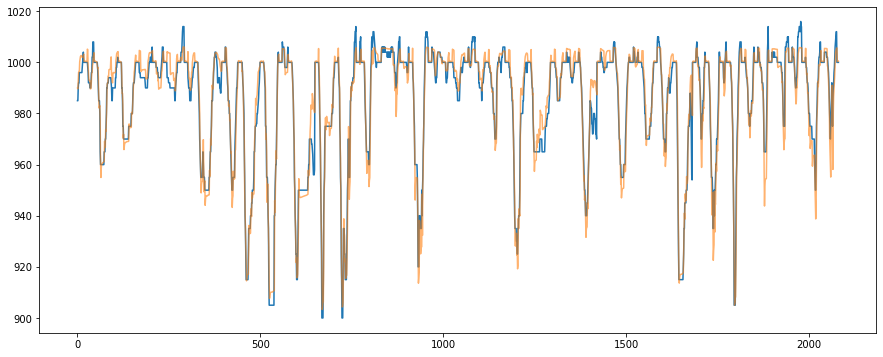

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(np.arange(0, len(test_y6)), test_y6)
plt.plot(np.arange(0, len(lstm_p2_pred)), lstm_p2_pred, alpha=0.6)

<b> Typhoon Track forecasting from 4 tracing features (wind speed, pressure, latitude, longitude): </b>

Trajectories had been popular in typhoon research. In this study, the specified LSTM was trained and tested to predict the 6-hour latitude and longitude, the MAE for latitude was 3.567 degrees, and that for longitude was 3.207 degrees. Smaller errors found on longitude than on latitude might be explained by the more irregularities and uncertainties of typhoon moving in the northward directions due to Earth’s trade winds, impacts from ocean currents and continental impacts. Typically, a typhoon might be moving horizontally to affect South China Sea, bending greatly across Japan and the temperate zone, or going straight to hit Taiwan. These would be of large variations in latitudes.

To visualize the predicted and actual historical tracks, the package "basemap" was used to incorporate latitude and longitude intersected grids with the land boundary of the Eastern Asia (or Western Pacific) region. Blue-colored dots represented the track from model predictions while orange-colored dots represented the actual path of the typhoon. 

Below graphs would be showing some selected typhoons to investigate the variations of their predicted and historical paths. 
<ul>
<li>The first was the well-known Typhoon Mangkhut. The longitudes were basically aligned, but the latitudes differed by around 3 to 4 degrees.</li>
<li>The second was Typhoon Hagibis causing destructions in Japan. The predicted path estimated the landfall occurring in West Japan but actually the storm moved along the eastern coast of Japan affecting Tokyo. </li>
<li>The predicted trajectories for the bottom 4 typhoons (ShanShan, Cimaron, Krosa, Bailu) were significantly better, yet these were weak or intermediately-strong typhoons with relatively shorter ranges of movements. Obvious for the cases of ShanShan, Cimaron and Krosa, the model could not learn precisely the behaviours for the last few timesteps before the typhoon was about to dissipate. The reason for that might be at high latitudes tropical storms were generally more susceptible to the localized weather conditions, and strong trade winds from continents would make it more difficult to predict due to increasing variance.


In [ ]:
input_lat_x, dense_lat = LSTM_from_4_Tracking_features()
input_lon_x, dense_lon = LSTM_from_4_Tracking_features()

output_lat = Dense(1, activation='linear')(dense_lat)
output_lon = Dense(1, activation='linear')(dense_lon)

lstm_lat = Model(inputs = input_lat_x, outputs = output_lat)
lstm_lat.compile(loss='mse', optimizer=optim2, metrics=['mae'])
lstm_lon = Model(inputs = input_lon_x, outputs = output_lon)
lstm_lon.compile(loss='mse', optimizer=optim2, metrics=['mae'])

In [ ]:
train_X7, train_y7, val_X7, val_y7, test_X7, test_y7 = \
        feature_vector_track_4[0:int(len(feature_vector_track_4)*0.7)], \
        pad_target_lat[0:int(len(pad_target_lat)*0.7)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.7):int(len(feature_vector_track_4)*0.8)], \
        pad_target_lat[int(len(pad_target_lat)*0.7):int(len(pad_target_lat)*0.8)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.8):], \
        pad_target_lat[int(len(pad_target_lat)*0.8):]

train_X8, train_y8, val_X8, val_y8, test_X8, test_y8 = \
        feature_vector_track_4[0:int(len(feature_vector_track_4)*0.7)], \
        pad_target_lon[0:int(len(pad_target_lon)*0.7)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.7):int(len(feature_vector_track_4)*0.8)], \
        pad_target_lon[int(len(pad_target_lon)*0.7):int(len(pad_target_lon)*0.8)], \
        feature_vector_track_4[int(len(feature_vector_track_4)*0.8):], \
        pad_target_lon[int(len(pad_target_lon)*0.8):]

In [ ]:
lstm_lat.fit(train_X7, train_y7, batch_size=1, epochs=30,
              validation_data=(val_X7, val_y7),
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/30
7283/7283 [==============================] - 44s 6ms/step - loss: 1342.9499 - mae: 22.6985 - val_loss: 89.1337 - val_mae: 3.6244
Epoch 2/30
7283/7283 [==============================] - 42s 6ms/step - loss: 126.1777 - mae: 5.3481 - val_loss: 91.4561 - val_mae: 3.5673
Epoch 3/30
7283/7283 [==============================] - 41s 6ms/step - loss: 124.6117 - mae: 5.2036 - val_loss: 89.4495 - val_mae: 3.5999
Epoch 4/30
7283/7283 [==============================] - 42s 6ms/step - loss: 121.7581 - mae: 4.9225 - val_loss: 85.8835 - val_mae: 3.6008
Epoch 5/30
7283/7283 [==============================] - 41s 6ms/step - loss: 97.7308 - mae: 4.3153 - val_loss: 107.7302 - val_mae: 6.3513
Epoch 6/30
7283/7283 [==============================] - 41s 6ms/step - loss: 107.0057 - mae: 4.4721 - val_loss: 88.1053 - val_mae: 4.3129
Epoch 7/30
7283/7283 [==============================] - 42s 6ms/step - loss: 103.0442 - mae: 4.3620 - val_loss: 82.2632 - val_mae: 3.1560
Epoch 8/30
7283/7283 [==========

In [ ]:
lstm_lon.fit(train_X8, train_y8, batch_size=1, epochs=30,
              validation_data=[val_X8, val_y8],
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 7283 samples, validate on 1041 samples
Epoch 1/30
7283/7283 [==============================] - 39s 5ms/step - loss: 94.4339 - mae: 5.5216 - val_loss: 29.4303 - val_mae: 2.4181
Epoch 2/30
7283/7283 [==============================] - 38s 5ms/step - loss: 32.0122 - mae: 2.6122 - val_loss: 30.2664 - val_mae: 2.8332
Epoch 3/30
7283/7283 [==============================] - 38s 5ms/step - loss: 30.6912 - mae: 2.4493 - val_loss: 27.3028 - val_mae: 2.2379
Epoch 4/30
7283/7283 [==============================] - 38s 5ms/step - loss: 29.9392 - mae: 2.3656 - val_loss: 26.0193 - val_mae: 1.8601
Epoch 5/30
7283/7283 [==============================] - 38s 5ms/step - loss: 29.7358 - mae: 2.3403 - val_loss: 35.0173 - val_mae: 3.9325
Epoch 6/30
7283/7283 [==============================] - 39s 5ms/step - loss: 29.7261 - mae: 2.3362 - val_loss: 26.2712 - val_mae: 2.0043
Epoch 7/30
7283/7283 [==============================] - 38s 5ms/step - loss: 29.6964 - mae: 2.3156 - val_loss: 32.4319 - val_mae: 

In [ ]:
lstm_lat_pred = lstm_lat.predict(test_X7, batch_size=1)

In [ ]:
lstm_lon_pred = lstm_lon.predict(test_X8, batch_size=1)

In [ ]:
mean_absolute_error(test_y7, lstm_lat_pred)

3.566882432005487

In [ ]:
mean_absolute_error(test_y8, lstm_lon_pred)

3.2071572327731266

In [ ]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
from mpl_toolkits.basemap import Basemap

In [ ]:
lat_lon_collect = []
lat_lon_pred = []
lat_lon_collect_sub = []
lat_lon_pred_sub = []
for i in range(len(test_y7)-1):
    if test_y4[i] != 0:
        lat_lon_collect_sub.append((test_y7[i], test_y8[i]))
        lat_lon_pred_sub.append((lstm_lat_pred[i][0], lstm_lon_pred[i][0]))
    if len(lat_lon_collect_sub) != 0:
        if test_y4[i+1] == 0:
            lat_lon_collect.append(lat_lon_collect_sub)
            lat_lon_pred.append(lat_lon_pred_sub)
            lat_lon_collect_sub = []
            lat_lon_pred_sub = []

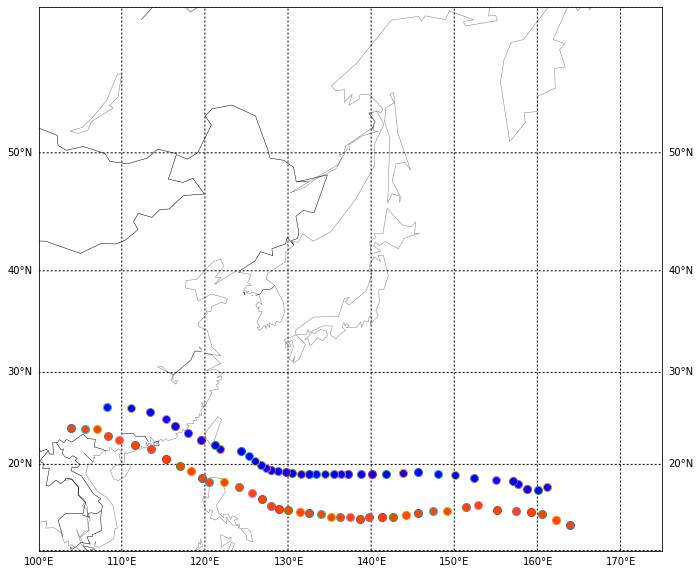

In [ ]:
## Typhoon MangKhut

fig = plt.figure(num=None, figsize=(14,10))
ax = plt.gca()
m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,llcrnrlon=100,urcrnrlon=175,resolution='c')
m.drawcoastlines(linewidth=0.5, color='gray')
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2])
m.drawcountries(linewidth=0.5, linestyle='solid', color='k') 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')

for x, y in lat_lon_collect[12]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="orangered", markersize=8)

for x, y in lat_lon_pred[12]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="blue", markersize=8)

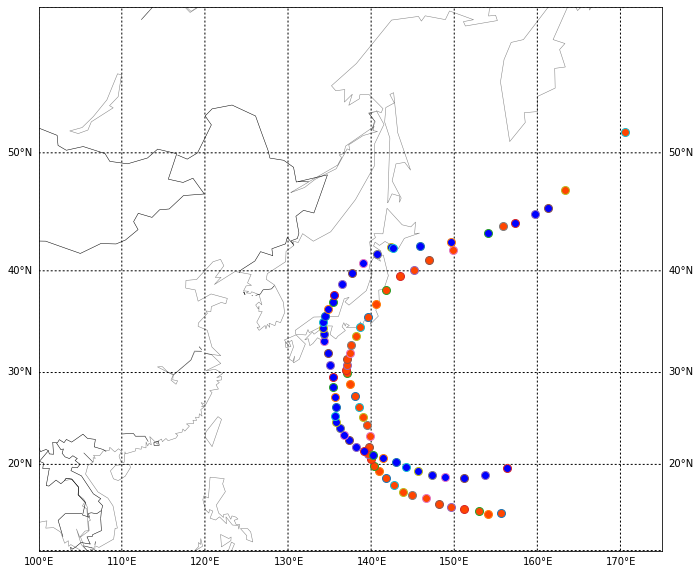

In [ ]:
## Typhoon Hagibis

fig = plt.figure(num=None, figsize=(14,10))
ax = plt.gca()
m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,llcrnrlon=100,urcrnrlon=175,resolution='c')
m.drawcoastlines(linewidth=0.5, color='gray')
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2])
m.drawcountries(linewidth=0.5, linestyle='solid', color='k') 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')

for x, y in lat_lon_collect[38]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="orangered", markersize=8)

for x, y in lat_lon_pred[38]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="blue", markersize=8)

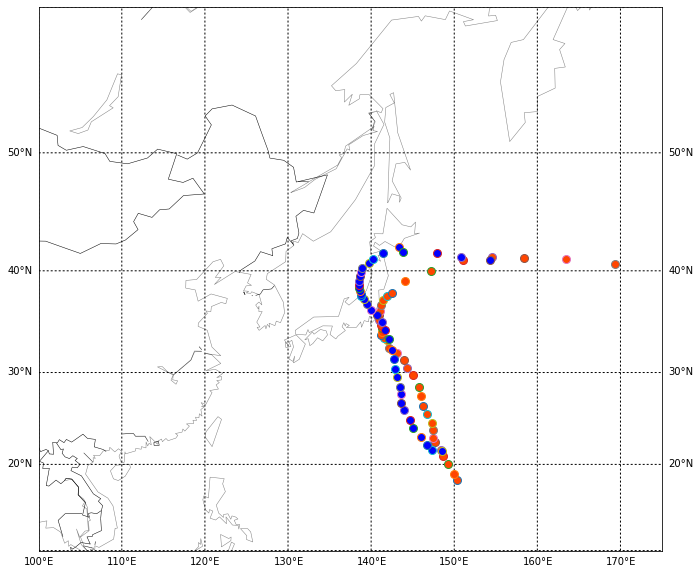

In [ ]:
## Typhoon ShanShan

fig = plt.figure(num=None, figsize=(14,10))
ax = plt.gca()
m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,llcrnrlon=100,urcrnrlon=175,resolution='c')
m.drawcoastlines(linewidth=0.5, color='gray')
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2])
m.drawcountries(linewidth=0.5, linestyle='solid', color='k') 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')

for x, y in lat_lon_collect[3]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="orangered", markersize=8)

for x, y in lat_lon_pred[3]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="blue", markersize=8)

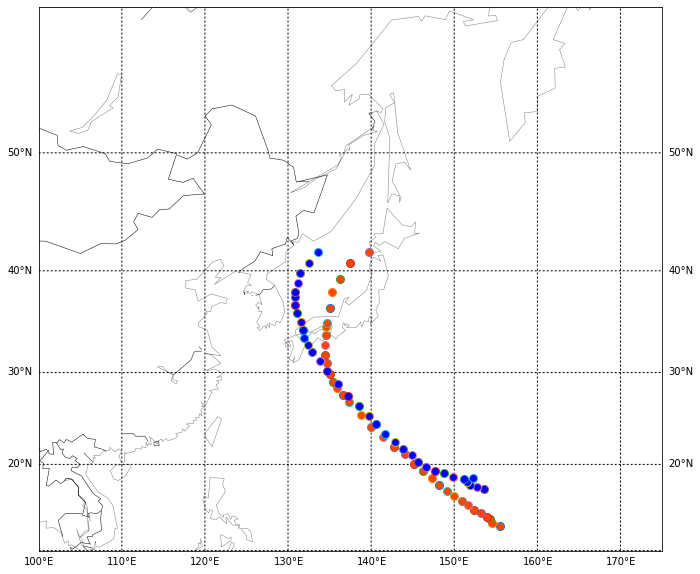

In [ ]:
## Typhoon Cimaron

fig = plt.figure(num=None, figsize=(14,10))
ax = plt.gca()
m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,llcrnrlon=100,urcrnrlon=175,resolution='c')
m.drawcoastlines(linewidth=0.5, color='gray')
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2])
m.drawcountries(linewidth=0.5, linestyle='solid', color='k') 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')

for x, y in lat_lon_collect[10]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="orangered", markersize=8)

for x, y in lat_lon_pred[10]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="blue", markersize=8)

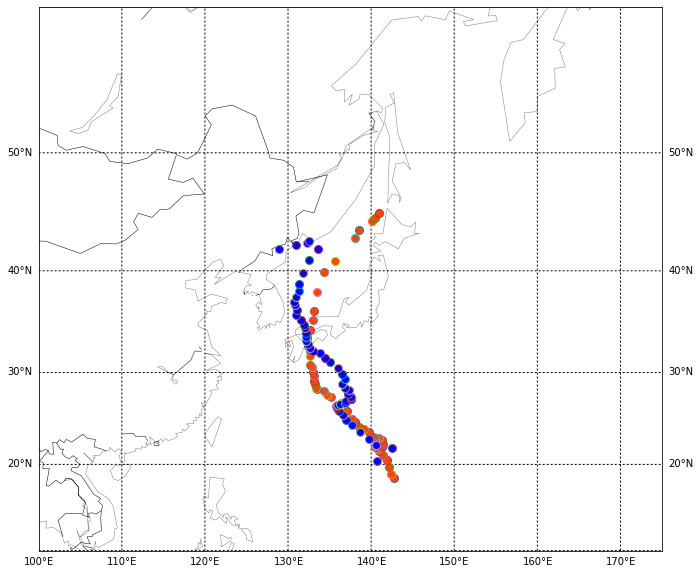

In [ ]:
## Typhoon Krosa

fig = plt.figure(num=None, figsize=(14,10))
ax = plt.gca()
m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,llcrnrlon=100,urcrnrlon=175,resolution='c')
m.drawcoastlines(linewidth=0.5, color='gray')
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2])
m.drawcountries(linewidth=0.5, linestyle='solid', color='k') 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')

for x, y in lat_lon_collect[29]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="orangered", markersize=8)

for x, y in lat_lon_pred[29]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="blue", markersize=8)

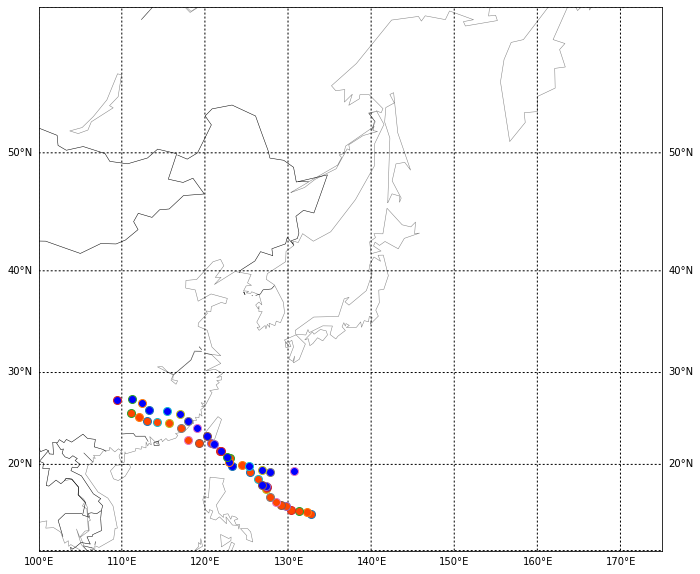

In [ ]:
## Typhoon Bailu

fig = plt.figure(num=None, figsize=(14,10))
ax = plt.gca()
m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,llcrnrlon=100,urcrnrlon=175,resolution='c')
m.drawcoastlines(linewidth=0.5, color='gray')
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2])
m.drawcountries(linewidth=0.5, linestyle='solid', color='k') 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')

for x, y in lat_lon_collect[30]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="orangered", markersize=8)

for x, y in lat_lon_pred[30]:
    x, y = m(x, y)
    plt.plot(x, y, marker='o', fillstyle='full', markerfacecolor="blue", markersize=8)

<b> Using a 5-Dimensional input for ConvLSTM to predict the peak strongness of typhoons: </b>

A variant or alternative to CNN-LSTM would be ConvLSTM, instead of connecting the CNN extracting the latent trained and flattened image vectors and passing them to LSTM, the image pixels would be directly used as inputs for the LSTM. In such approach, internal matrix multiplications would be replaced with convolution operations during each single timestep when flowing in one sample or one batch of image data throughout the LSTM cell, this would persist the spatial characteristics and dependency because the changes of each small frame (local region) on the image over the temporal space could be recognized and analyzed. The dimensionality of the input tensor for ConvLSTM would hence be a 5-D array of shape = (n_sample, n_timestep, image_height, image_width, n_channels). 

<img src="../pic/convlstm.png"/>

Reference: https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7

ConvLSTM was widely applied in video data involving a series of images over time, like doing video thematic classification, video captioning, object detection in videos, etc. In this case, I tried to use the recorded satellite images during the first 3-day (i.e. 12 timesteps) of typhoon formation, to predict the maximum wind speed (or highest intensity category) and the minimum atmospheric pressure the typhoon could finally achieve.

For the training set, the results were quite good:
<ul>
<li> Intensity Category: accuracy = 93%; </li>
<li> Wind Speed: mean absoulte error = 9.1531; </li>
<li> Air Pressure: mean absoulte error = 16.1425; </li>
</ul>

Hoever, for the testing set, the performance showed overfitting problem:
<ul>
<li> Intensity Category: accuracy = 48%; </li>
<li> Wind Speed: mean absoulte error = 18.2330; </li>
<li> Air Pressure: mean absoulte error = 35.4077; </li>
</ul>

The satellite image contributed limited effects on forecasting long-term development of a typhoon, but for short-term, as shown in above parts, it could help improve the forecast that was only relying on the past physical data observed. 

In [ ]:
from keras.layers import ConvLSTM2D, MaxPooling3D, GlobalMaxPooling1D

In [ ]:
track_df_category = track_df[['identity','timestep','category']].pivot('identity','timestep')
track_df_windspeed = track_df[['identity','timestep','wind']].pivot('identity','timestep')
track_df_pressure = track_df[['identity','timestep','pressure']].pivot('identity','timestep')

 Shortest Lifetime of typhoons in the dataset: 3
 Longest Lifetime of typhoons in the dataset: 112


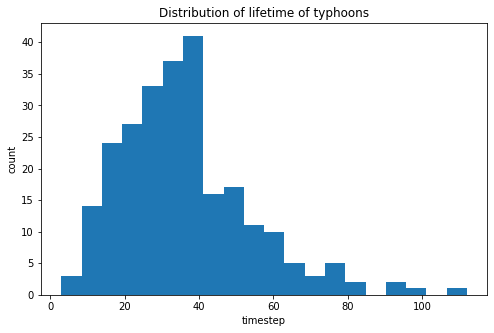

In [ ]:
print(" Shortest Lifetime of typhoons in the dataset: " + str(min(track_df_category.count(axis=1))))
print(" Longest Lifetime of typhoons in the dataset: " + str(max(track_df_category.count(axis=1))))
plt.rcParams['figure.figsize'] = (8, 5)
plt.hist(track_df_category.count(axis=1), bins=20)
plt.title("Distribution of lifetime of typhoons")
plt.xlabel("timestep")
plt.ylabel("count")
plt.show()

In [ ]:
needed_image_index_list = []
for k in range(sort_image.shape[0]):
  if sort_image['seq_num'][k] <= 12:
    needed_image_index_list.append(k)

In [ ]:
output_array = np.zeros((252, 12, 512, 512, 3), dtype=np.int8)

In [ ]:
iter = 0
for x in range(252):
  for y in range(12):
    if pd.isnull(track_df_category.iloc[x,y]) == False:
      output_array[x][y] = image_array['arr'][needed_image_index_list[iter]]
      iter += 1
    else:
      output_array[x][y] = np.full((512, 512, 3), -255)

In [ ]:
## get the maximum category of intensity, wind speed and air pressure
target_max_category = track_df_category.apply(pd.to_numeric).max(axis=1, skipna=True)
target_max_category = [int(x) for x in target_max_category]
target_max_windspeed = track_df_windspeed.apply(pd.to_numeric).max(axis=1, skipna=True)
target_min_pressure = track_df_pressure.apply(pd.to_numeric).min(axis=1, skipna=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
target_max_category_oh = OneHotEncoder().fit(np.array(target_max_category).reshape(-1,1))
target_max_category_oh_arr = target_max_category_oh.transform(np.array(target_max_category).reshape(-1,1)).toarray()

In [ ]:
train_convlstm_img = output_array[0:(252-29)]
test_convlstm_img = output_array[(252-29):]
train_convlstm_y1 = target_max_category_oh_arr[0:(252-29)]
test_convlstm_y1 = target_max_category_oh_arr[(252-29):]
train_convlstm_y2 = target_max_windspeed[0:(252-29)]
test_convlstm_y2 = target_max_windspeed[(252-29):]
train_convlstm_y3 = target_min_pressure[0:(252-29)]
test_convlstm_y3 = target_min_pressure[(252-29):]

In [ ]:
print(train_convlstm_img.shape)
print(test_convlstm_img.shape)
print(train_convlstm_y1.shape)
print(test_convlstm_y1.shape)

(223, 12, 512, 512, 3)
(29, 12, 512, 512, 3)
(223, 4)
(29, 4)


In [ ]:
def convLSTM():

    input_x = Input(shape=(None,512,512,3))
    ConvLSTM_0 = ConvLSTM2D(filters=4, kernel_size=(3, 3), padding="same", return_sequences=True)(input_x)
    max_pool_0 = MaxPooling3D(pool_size=(1,2,2))(ConvLSTM_0)
    ConvLSTM_1 = ConvLSTM2D(filters=8, kernel_size=(3, 3), padding="same", return_sequences=True)(max_pool_0)
    bn_1 = BatchNormalization()(ConvLSTM_1)
    max_pool_1 = MaxPooling3D(pool_size=(1,2,2))(bn_1)
    ConvLSTM_2 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True)(max_pool_1)
    bn_2 = BatchNormalization()(ConvLSTM_2)
    max_pool_2 = MaxPooling3D(pool_size=(1,2,2))(bn_2)
    ConvLSTM_3 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True)(max_pool_2)
    bn_3 = BatchNormalization()(ConvLSTM_3)
    max_pool_3 = MaxPooling3D(pool_size=(1,2,2))(bn_3)
    ConvLSTM_4 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True)(max_pool_3)
    bn_4 = BatchNormalization()(ConvLSTM_4)
    max_pool_4 = MaxPooling3D(pool_size=(1,2,2))(bn_4)

    flat_layer = TimeDistributed(Flatten())(max_pool_4)
    first_Dense = Dense(100, activation='relu')(flat_layer)
    second_Dense = Dense(50, activation='relu')(first_Dense)
    third_Dense = Dense(25, activation='relu')(second_Dense)
    output_flatten = GlobalMaxPooling1D()(third_Dense)

    return input_x, output_flatten

input_convlstm1, dense_c = convLSTM()
input_convlstm2, dense_p = convLSTM()
input_convlstm3, dense_w = convLSTM()

output_y1 = Dense(4, activation='softmax')(dense_c)
output_y2 = Dense(1, activation='linear')(dense_p)
output_y3 = Dense(1, activation='linear')(dense_w)

convlstm_y1 = Model(inputs = input_convlstm1, outputs = output_y1)
convlstm_y2 = Model(inputs = input_convlstm2, outputs = output_y2)
convlstm_y3 = Model(inputs = input_convlstm3, outputs = output_y3)

adam = Adam(learning_rate=1e-5)

convlstm_y1.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
convlstm_y2.compile(loss='mse', optimizer=adam, metrics = ['mae'])
convlstm_y3.compile(loss='mse', optimizer=adam, metrics = ['mae'])

In [ ]:
convlstm_y1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 512, 512, 3 0         
_________________________________________________________________
conv_lst_m2d_15 (ConvLSTM2D) (None, None, 512, 512, 4) 1024      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, None, 256, 256, 4) 0         
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (None, None, 256, 256, 8) 3488      
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 256, 256, 8) 32        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, None, 128, 128, 8) 0         
_________________________________________________________________
conv_lst_m2d_17 (ConvLSTM2D) (None, None, 128, 128, 16 1388

In [ ]:
from collections import Counter
target_max_category_count = Counter(target_max_category)

In [ ]:
{0: max(target_max_category_count.values()) / target_max_category_count[3], 
                              1: max(target_max_category_count.values()) / target_max_category_count[4], 
                              2: max(target_max_category_count.values()) / target_max_category_count[5], 
                              3: max(target_max_category_count.values()) / target_max_category_count[6]}

{0: 2.2264150943396226, 1: 4.214285714285714, 2: 2.2264150943396226, 3: 1.0}

In [ ]:
convlstm_y1.fit(train_convlstm_img, train_convlstm_y1, batch_size=1, epochs=15,
                class_weight={0: max(target_max_category_count.values()) / target_max_category_count[3], 
                              1: max(target_max_category_count.values()) / target_max_category_count[4], 
                              2: max(target_max_category_count.values()) / target_max_category_count[5], 
                              3: max(target_max_category_count.values()) / target_max_category_count[6]})

Epoch 1/15
223/223 [==============================] - 81s 295ms/step - loss: 5.4794 - accuracy: 0.4346
Epoch 2/15
223/223 [==============================] - 67s 299ms/step - loss: 2.8211 - accuracy: 0.4469
Epoch 3/15
223/223 [==============================] - 67s 300ms/step - loss: 2.3987 - accuracy: 0.4644
Epoch 4/15
223/223 [==============================] - 67s 301ms/step - loss: 2.1812 - accuracy: 0.5426
Epoch 5/15
223/223 [==============================] - 67s 300ms/step - loss: 2.0462 - accuracy: 0.6398
Epoch 6/15
223/223 [==============================] - 66s 298ms/step - loss: 1.8791 - accuracy: 0.7217
Epoch 7/15
223/223 [==============================] - 67s 299ms/step - loss: 1.7610 - accuracy: 0.7371
Epoch 8/15
223/223 [==============================] - 66s 298ms/step - loss: 1.6768 - accuracy: 0.8452
Epoch 9/15
223/223 [==============================] - 67s 299ms/step - loss: 1.5435 - accuracy: 0.8993
Epoch 10/15
223/223 [==============================] - 67s 299ms/step - l

In [ ]:
convlstm_y2.fit(train_convlstm_img, train_convlstm_y2, batch_size=1, epochs=30)

Epoch 1/30
223/223 [==============================] - 78s 283ms/step - loss: 4466.3501 - mae: 61.7731
Epoch 2/30
223/223 [==============================] - 66s 294ms/step - loss: 1399.9618 - mae: 29.6551
Epoch 3/30
223/223 [==============================] - 66s 295ms/step - loss: 670.0664 - mae: 22.6795
Epoch 4/30
223/223 [==============================] - 66s 296ms/step - loss: 625.2160 - mae: 22.1798
Epoch 5/30
223/223 [==============================] - 66s 296ms/step - loss: 606.0266 - mae: 21.6122
Epoch 6/30
223/223 [==============================] - 66s 295ms/step - loss: 520.9070 - mae: 19.3869
Epoch 7/30
223/223 [==============================] - 66s 295ms/step - loss: 494.0226 - mae: 18.6880
Epoch 8/30
223/223 [==============================] - 66s 295ms/step - loss: 465.9764 - mae: 18.5033
Epoch 9/30
223/223 [==============================] - 66s 296ms/step - loss: 456.1752 - mae: 18.0426
Epoch 10/30
223/223 [==============================] - 66s 296ms/step - loss: 436.8609 - 

In [ ]:
convlstm_y3.fit(train_convlstm_img, train_convlstm_y3, batch_size=1, epochs=60)

Epoch 1/60
223/223 [==============================] - 61s 213ms/step - loss: 922933.8920 - mae: 960.1730
Epoch 2/60
223/223 [==============================] - 48s 213ms/step - loss: 859895.1719 - mae: 926.6015
Epoch 3/60
223/223 [==============================] - 47s 212ms/step - loss: 629823.8761 - mae: 791.2325
Epoch 4/60
223/223 [==============================] - 47s 212ms/step - loss: 261445.5984 - mae: 504.3091
Epoch 5/60
223/223 [==============================] - 47s 213ms/step - loss: 42595.1877 - mae: 198.1854
Epoch 6/60
223/223 [==============================] - 47s 213ms/step - loss: 2827.8832 - mae: 45.5216
Epoch 7/60
223/223 [==============================] - 47s 213ms/step - loss: 1149.9825 - mae: 28.3396
Epoch 8/60
223/223 [==============================] - 47s 213ms/step - loss: 1029.1807 - mae: 27.1502
Epoch 9/60
223/223 [==============================] - 47s 212ms/step - loss: 1124.2397 - mae: 27.3027
Epoch 10/60
223/223 [==============================] - 47s 212ms/ste

In [ ]:
pred_y1 = convlstm_y1.predict(test_convlstm_img, batch_size=1)

In [ ]:
pred_y2 = convlstm_y2.predict(test_convlstm_img, batch_size=1)

In [ ]:
pred_y3 = convlstm_y3.predict(test_convlstm_img, batch_size=1)

In [ ]:
pred_y1_train = convlstm_y1.predict(train_convlstm_img, batch_size=1)

In [ ]:
pred_y2_train = convlstm_y2.predict(train_convlstm_img, batch_size=1)

In [ ]:
pred_y3_train = convlstm_y3.predict(train_convlstm_img, batch_size=1)

In [ ]:
mean_absolute_error(train_convlstm_y2, pred_y2_train)

9.153138639681007

In [ ]:
mean_absolute_error(test_convlstm_y2, pred_y2)

18.23302854340652

In [ ]:
mean_absolute_error(train_convlstm_y3, pred_y3_train)

16.14248522087063

In [ ]:
mean_absolute_error(test_convlstm_y3, pred_y3)

35.40766256700182

              precision    recall  f1-score   support

           0       0.98      0.85      0.91        47
           2       1.00      0.69      0.82        26
           3       0.89      1.00      0.94        48
           4       0.93      1.00      0.96       102

    accuracy                           0.93       223
   macro avg       0.95      0.89      0.91       223
weighted avg       0.94      0.93      0.93       223



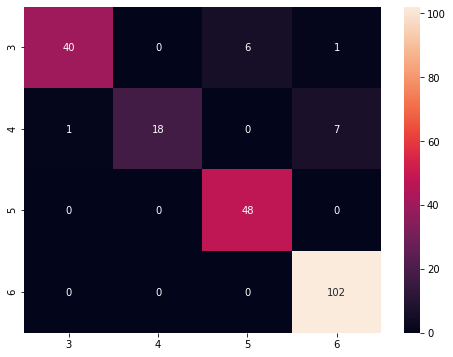

In [ ]:
print(classification_report([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in train_convlstm_y1], 
                            [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in pred_y1_train]))

plt.rcParams['figure.figsize'] = (8, 6)
seaborn.heatmap(confusion_matrix([np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in train_convlstm_y1], 
                                 [np.argmax(x)+1 if np.argmax(x)!=0 else np.argmax(x) for x in pred_y1_train]),
                annot=True, fmt="d", xticklabels=[3,4,5,6], yticklabels=[3,4,5,6])

              precision    recall  f1-score   support

           0       0.29      0.33      0.31         6
           1       0.25      0.50      0.33         2
           2       0.33      0.20      0.25         5
           3       0.67      0.62      0.65        16

    accuracy                           0.48        29
   macro avg       0.38      0.41      0.38        29
weighted avg       0.50      0.48      0.49        29



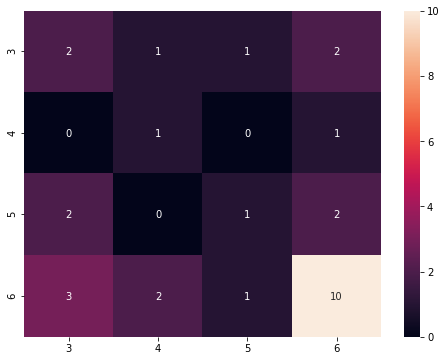

In [ ]:
print(classification_report([np.argmax(x) for x in test_convlstm_y1], 
                            [np.argmax(x) for x in pred_y1]))

plt.rcParams['figure.figsize'] = (8, 6)
seaborn.heatmap(confusion_matrix([np.argmax(x) for x in test_convlstm_y1], 
                                 [np.argmax(x) for x in pred_y1]),
                annot=True, fmt="d", xticklabels=[3,4,5,6], yticklabels=[3,4,5,6])